Este notebook es sobre el análisis de texto de títulos que aparecen en 5 sitios de noticias de Uruguay. Particularmente se analizan 8 días consecutivos de la publicación de esos sitios. Se analiza la frecuencia de palabras, se realizan nubes de palabras, se extraen tópicos a traves de modelos LDA. También se calcula la correlación entre esos sitios en relación al uso de las palabras y se describie el sentimiento de los títulos que aparecen en esos sitios. El etiquetado se realizó con el paquete pysentimiento.


In [ ]:
!pip install contexto

In [ ]:
from contexto.limpieza import * # Esta es uno de los paquetes dentro de contexto que se centra en la limpieza del texto
from contexto.exploracion import grafica_barchart_frecuencias # gráfico de frecuencias usando ConTexto
from contexto.exploracion import obtener_ngramas, par_nubes # nubes de palabras usando ConTexto

import pandas as pd # paquete necesario para trabajar con DataFrame

!pip install matplotlib==3.1.3 # Esta versión permite realizar los gráficos a pesar de que ConTexto viene con una versión más actualizada de matplotlib

import itertools # Este paquete es para pasar de una lista de lista a un flat y luego pasarlo a una lista

import numpy as np


In [3]:
import pandas as pd # paquete necesario para trabajar con DataFrame

import nltk # paquete para trabajar con análisis de textos.
from nltk.corpus import stopwords # incorporación de stopwords
from nltk.tokenize import wordpunct_tokenize # permite la tokenización del texto

nltk.download('stopwords') # se baja las stopwords
nltk.download('punkt') # no estoy segura pero creo que es necesaria para las stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# Para lemmatizar el texto, en este caso uso Stanza

from contexto.lematizacion import LematizadorSpacy, LematizadorStanza 
from contexto.lematizacion import lematizar_texto

In [ ]:
!pip install pyLDAvis==3.2.2 # Esto es para la visualización de LDA

In [6]:
import gensim # necesito importar este paquete para luego construir el modelo LDA
from gensim import corpora
from gensim.models import CoherenceModel# Coherence score and perplexity provide a convinent way to measure how good a given topic model is
import pyLDAvis.gensim

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [7]:
stop_words = list(stopwords.words('spanish'))
espanol = pd.read_csv('spanish.txt', header=None)
espanol.columns = ['palabra']
list_espanol = list(espanol['palabra'])
stop_words.extend(list_espanol)

unique_stop_words = []
[unique_stop_words.append(word) for word in stop_words if word not in unique_stop_words]
len(unique_stop_words)

615

In [8]:
base = pd.read_csv('base_tit_senti_fecha.csv', encoding='iso8859_2')
base_periodo = base[(base['fecha'] <= '2021-07-30') & (base['fecha'] >= '2021-07-23')]

In [9]:
def limpiar_tokenizar(texto):
    lematizador = LematizadorSpacy('es')
    nuevo_texto = limpieza_texto(texto, n_min=3, quitar_acentos=True, quitar_numeros=True, lista_palabras = unique_stop_words)
    nuevo_texto = wordpunct_tokenize(nuevo_texto)# esto toma espacios, símbolos, comas, etc. y los tokeniza junto con las palabras
    nuevo_texto = [token for token in nuevo_texto if len(token) > 3]
    nuevo_texto = [lematizar_texto(word, lematizador=lematizador) for word in nuevo_texto]
    
    return(nuevo_texto)

In [10]:
base_periodo['tit_tokenizado'] = base_periodo['titular'].apply(lambda x: limpiar_tokenizar(x)) # Tengo el archivo guardado no hay necesidad de hacer correr este código
# ya que demora algo más de 1 hora. Algo no funciona con ese archivo así que hay que correrlo para seguir con el cuaderno.

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


[INFO] Descargando modelo. Este proceso puede tardar varios minutos.


[INFO] El modelo ha sido descargado.
[INFO] Por favor correr de nuevo el script, o iniciar una nueva sesión de Python para cargarlo.
[INFO] Hasta entonces, se utilizará un modelo en blanco.



<ipython-input-10-a75fc44fea7e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_periodo['tit_tokenizado'] = base_periodo['titular'].apply(lambda x: limpiar_tokenizar(x)) # Tengo el archivo guardado no hay necesidad de hacer correr este código


In [ ]:
#from google.colab import files
#base_periodo.to_csv("base_periodo.csv")

#files.download('base_periodo.csv')

In [ ]:
#base_periodo['tit_tokenizado'] = base_periodo['titular'].map(limpiar_tokenizar) #esta es otra opción en lugar de usar apply, no cambia mucho la cosa en relación a la velocidad.

In [11]:
#base_periodo = pd.read_csv('base_periodo.csv') # subir desde la carpeta

base_periodo

titular       fecha  diario  \
0      "Mirá la ceremonia de inauguración de los Jueg...  2021-07-23  elobse   
1      "El contrasentido del clásico: Peńarol perdió ...  2021-07-23  elobse   
2      "Los sueldos de $ 200.000 en el Directorio de ...  2021-07-23  elobse   
3      "żDónde se podrán ver los Juegos Olímpicos de ...  2021-07-23  elobse   
4      "Crece interés de argentinos por Montevideo: c...  2021-07-23  elobse   
...                                                  ...         ...     ...   
83764                 "El segundo Exilio"                 2021-07-30  republ   
83765  "El sondeo del Grupo R Multimedio sobre la LUC...  2021-07-30  republ   
83766  "Lacalle Pou recibe hoy a legisladores oficial...  2021-07-30  republ   
83767  "Suplemento Especial Puertos Del Uruguay"     ...  2021-07-30  republ   
83768  "Suplemento Empresa Y Negocio  30 de Julio de...  2021-07-30  republ   

      sentimiento                                     tit_tokenizado  
0             NEU                                       [, , , , , ]  
1             NEU  [contrasentido, clasico, penarol, perdar, canc...  
2             NEU  [sueldo, directorio, caja, profesional, propue...  
3             NEU         [zdonde, juegos, olimpico, tokio, uruguay]  
4             POS  [crecer, inter, argentino, montevideo, compra,...  
...           ...                                                ...  
83764         NEU                                           [exilio]  
83765         NEU                        [sondeo, grupo, multimedio]  
83766         NEU  [lacalle, recibir, legislador, oficialista, pu...  
83767         NEU            [suplemento, especial, puerto, uruguay]  
83768         NEU              [suplemento, empresa, negocio, julio]  

[2758 rows x 5 columns]

In [ ]:
base_elobse = base_periodo[base_periodo['diario'] == 'elobse']
#base_elobse

tokenizado_elobse = list(base_elobse['tit_tokenizado'])
tokenizado_elobse
#len(tokenizado_elobse)

In [13]:
# flattening the list and storing the result
flat_list = itertools.chain(*tokenizado_elobse)
# converting iterable to list and printing
#tok = print(list(flat_list))
#flat_list
tok = list(flat_list)
token_elobse = " ".join(map(str, tok))
token_elobse

'      contrasentido clasico penarol perdar cancha ganar discusion sueldo directorio caja profesional propuesta honorario zdonde juegos olimpico tokio uruguay crecer inter argentino montevideo compra inmueble instalar colegio delgado orsi tension referente volveran encontrar él antiguo gratuito zhay chanz ganar fifa correctivo salarial pagar trabajador domestica julio obra har sorpresa falto argumentacion alcalde blanco opinar rechazo fideicomiso dilema patrocinador japonés juegos olimpico palpitar juegos olimpico tokio pais poblacion vacunado juegos olimpico zcomo impediran brote covid tokio operativo clasico detenido menor municipio plantear construir cancha futbol tenis espacio publico gimnasio club ampliar aforo socio vacunado trigo paso grano estrella proximo cosecha lograr ajuste proyecto regular teletrabajo aprobo diputado movido gerencial incorporación uruit universidad mirador panoramico montevideo cielo costa canelón mejor bar trago montevideo nacio hija pampita roberto garci

In [14]:
unigramas = obtener_ngramas(token_elobse, 1)
bigramas = obtener_ngramas(token_elobse, 2)

Acá el código para LDA, luego vendrán todos los gráficos juntos

In [15]:
dictionary_elobse = corpora.Dictionary(tokenizado_elobse)
dictionary_elobse.filter_extremes(no_below=3)# tenía esto y lo saqué: , keep_n=300

In [16]:
corpus_elobse = [dictionary_elobse.doc2bow(text) for text in tokenizado_elobse]

In [17]:
# Esto es para seleccionar la cantidad de tópicos, cuanto más alto mejor

results = []

for t in range(2, 10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus_elobse, id2word=dictionary_elobse, num_topics=t, passes=10)
    corpus_lda = lda_model[corpus_elobse]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, texts=tokenizado_elobse, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [18]:
results

topic     score
0      2  0.636553
1      3  0.624636
2      4  0.620248
3      5  0.597443
4      6  0.635774
5      7  0.623052
6      8  0.608423
7      9  0.564213

In [19]:
# Define the LDA model
ldamodel_elobse = gensim.models.ldamodel.LdaModel(corpus_elobse, num_topics=5, id2word=dictionary_elobse, passes=10)# revisar los argumentos

# Save the topics and top 5 words
topics = ldamodel_elobse.print_topics(num_words=10)

# Print the results
#lista_topic = []
for topic in topics:  
    print(topic)
    #lista_topic.append(topic)

#from google.colab import files

#lista_topic = pd.DataFrame(lista_topic)
#lista_topic.to_csv("topic_elosbe_1.csv")

#files.download('topic_elosbe_1.csv')

(0, '0.069*"olimpico" + 0.049*"juegos" + 0.037*"tokio" + 0.028*"tokyo" + 0.028*"montevideo" + 0.021*"mano" + 0.021*"servicio" + 0.021*"medalla" + 0.019*"mirador" + 0.019*"panoramico"')
(1, '0.045*"ano" + 0.032*"vacuna" + 0.024*"canelón" + 0.024*"costa" + 0.017*"uruguay" + 0.016*"plata" + 0.016*"mejor" + 0.014*"montevideo" + 0.014*"origen" + 0.014*"bidir"')
(2, '0.038*"uruguayo" + 0.030*"ganar" + 0.027*"olimpico" + 0.024*"uruguay" + 0.023*"empresa" + 0.018*"penarol" + 0.018*"eeuu" + 0.016*"peru" + 0.015*"mirar" + 0.013*"miranda "')
(3, '0.070*"uruguay" + 0.037*"mundo" + 0.029*"vacunado" + 0.025*"publicar" + 0.025*"caso" + 0.023*"covid" + 0.022*"buscar" + 0.022*"muerte" + 0.020*"opinion" + 0.020*"zquer"')
(4, '0.047*"pagina" + 0.030*"kluver" + 0.024*"observador" + 0.024*"acceder" + 0.024*"archivo" + 0.021*"cetraro" + 0.021*"millón" + 0.021*"volver" + 0.021*"final" + 0.015*"mundial"')


In [20]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_elobse.log_perplexity(corpus_elobse))  # a measure of how good the model is. lower the better.



Perplexity:  -5.90847882369467


In [21]:
lda_display_elobse = pyLDAvis.gensim.prepare(ldamodel_elobse, corpus_elobse, dictionary_elobse, sort_topics=False, R=10)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


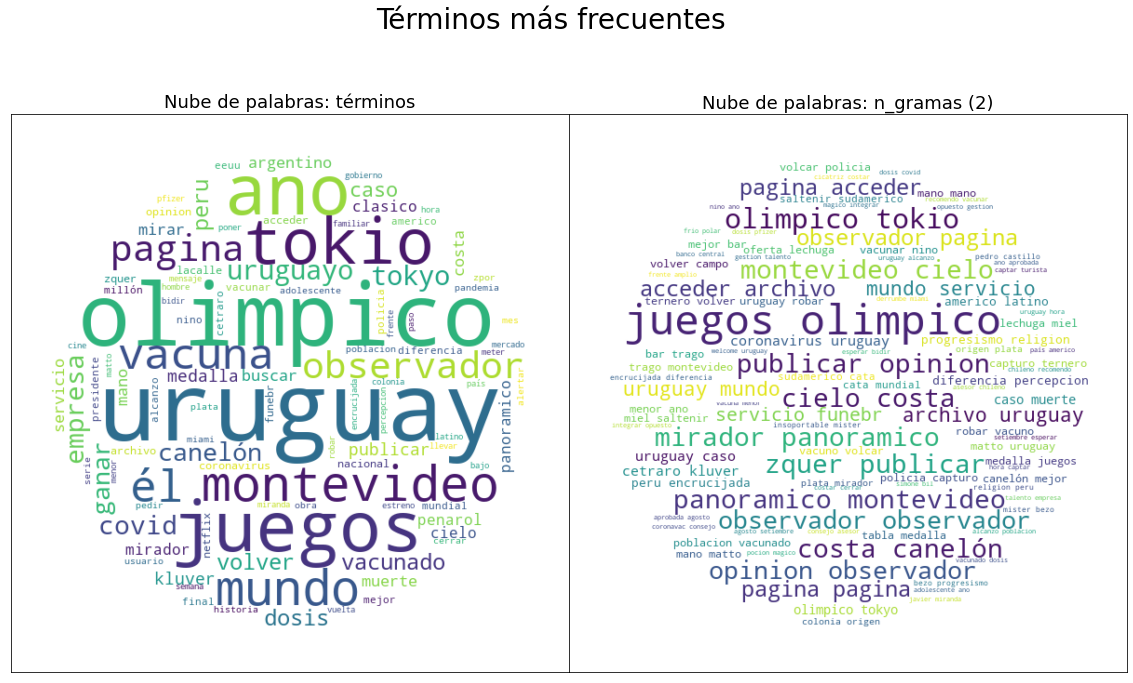

In [22]:
par_nubes(token_elobse, n1=1, n2=2, ubicacion_archivo='nube_uni_bi_elobse.jpg')

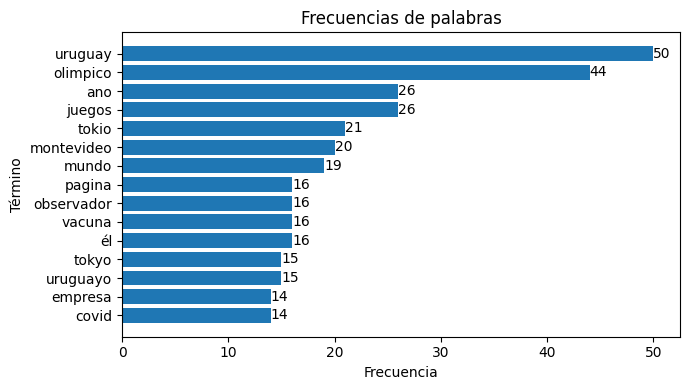

In [23]:
grafica_barchart_frecuencias(token_elobse, ubicacion_archivo='barras_palabras_elobse.jpg', 
                             titulo='Frecuencias de palabras', dim_figura=(7,4))

In [24]:
pyLDAvis.display(lda_display_elobse)

De acá para adelante considero el día como documento para hacer LDA

In [25]:
base_elobse = base_periodo[base_periodo['diario'] == 'elobse']
base_elobse

#tokenizado_elobse = list(base_elobse['tit_tokenizado'])
#tokenizado_elobse


titular       fecha  diario  \
0    "Mirá la ceremonia de inauguración de los Jueg...  2021-07-23  elobse   
1    "El contrasentido del clásico: Peńarol perdió ...  2021-07-23  elobse   
2    "Los sueldos de $ 200.000 en el Directorio de ...  2021-07-23  elobse   
3    "żDónde se podrán ver los Juegos Olímpicos de ...  2021-07-23  elobse   
4    "Crece interés de argentinos por Montevideo: c...  2021-07-23  elobse   
..                                                 ...         ...     ...   
544  "Las razones de la Justicia para habilitar la ...  2021-07-30  elobse   
545  "żQuerés publicar tu opinión en El Observador?...  2021-07-30  elobse   
546  "El Observador página a página: accedé al PDF ...  2021-07-30  elobse   
547   "El tiempo en Uruguay y en el mundo"              2021-07-30  elobse   
548             "Servicios fúnebres"                    2021-07-30  elobse   

    sentimiento                                     tit_tokenizado  
0           NEU                                       [, , , , , ]  
1           NEU  [contrasentido, clasico, penarol, perdar, canc...  
2           NEU  [sueldo, directorio, caja, profesional, propue...  
3           NEU         [zdonde, juegos, olimpico, tokio, uruguay]  
4           POS  [crecer, inter, argentino, montevideo, compra,...  
..          ...                                                ...  
544         NEU  [razón, justicia, habilitar, obra, inspirado, ...  
545         NEU             [zquer, publicar, opinion, observador]  
546         NEU     [observador, pagina, pagina, acceder, archivo]  
547         NEU                                   [uruguay, mundo]  
548         NEU                                 [servicio, funebr]  

[549 rows x 5 columns]

In [26]:

fecha_unica = base_elobse['fecha'].unique().tolist()
fecha_unica


['2021-07-23',
 '2021-07-24',
 '2021-07-25',
 '2021-07-26',
 '2021-07-27',
 '2021-07-28',
 '2021-07-29',
 '2021-07-30']

In [ ]:
Lista = []
for i in fecha_unica:
  data = base_elobse.loc[base_elobse['fecha'] == i]
  tok =list(data['tit_tokenizado'])
  Lista.append(tok)

Lista

In [28]:
frame_tok = pd.DataFrame()

frame_tok['Fechas'] = fecha_unica
frame_tok['Token'] = Lista



In [29]:
frame_tok

Fechas                                              Token
0  2021-07-23  [[, , , , , ], [contrasentido, clasico, penaro...
1  2021-07-24  [[adrian, pena, partido, colorado, fuerza, pro...
2  2021-07-25  [[lacalle, herrera, bisagra, herrerismo, reivi...
3  2021-07-26  [[diputado, cabildo, pedir, mantener, subsidio...
4  2021-07-27  [[declaracion, victima, operacion, oceano, gen...
5  2021-07-28  [[zquién, cetraro, kluver, borchi, llevar, uru...
6  2021-07-29  [[ente, advertir, conflictividad, lacalle, rat...
7  2021-07-30  [[carrera, espectacular, deborah, rodriguez, s...

In [30]:
frame_list = frame_tok['Token'].apply(lambda x: list(itertools.chain(*x)))

In [31]:
frame_list

0    [, , , , , , contrasentido, clasico, penarol, ...
1    [adrian, pena, partido, colorado, fuerza, prog...
2    [lacalle, herrera, bisagra, herrerismo, reivin...
3    [diputado, cabildo, pedir, mantener, subsidio,...
4    [declaracion, victima, operacion, oceano, gene...
5    [zquién, cetraro, kluver, borchi, llevar, urug...
6    [ente, advertir, conflictividad, lacalle, rati...
7    [carrera, espectacular, deborah, rodriguez, se...
Name: Token, dtype: object

In [32]:
elobse_frame_fechas = pd.DataFrame()

elobse_frame_fechas['Fecha'] = fecha_unica
elobse_frame_fechas['Tokens'] = frame_list

In [33]:
elobse_frame_fechas

Fecha                                             Tokens
0  2021-07-23  [, , , , , , contrasentido, clasico, penarol, ...
1  2021-07-24  [adrian, pena, partido, colorado, fuerza, prog...
2  2021-07-25  [lacalle, herrera, bisagra, herrerismo, reivin...
3  2021-07-26  [diputado, cabildo, pedir, mantener, subsidio,...
4  2021-07-27  [declaracion, victima, operacion, oceano, gene...
5  2021-07-28  [zquién, cetraro, kluver, borchi, llevar, urug...
6  2021-07-29  [ente, advertir, conflictividad, lacalle, rati...
7  2021-07-30  [carrera, espectacular, deborah, rodriguez, se...

In [ ]:
tokenizado_elobse_fechas = list(elobse_frame_fechas['Tokens'])
tokenizado_elobse_fechas

In [35]:
dictionary_elobse_tok = corpora.Dictionary(tokenizado_elobse_fechas)
dictionary_elobse_tok.filter_extremes(no_below=3)# tenía esto y lo saqué: , keep_n=300

In [37]:
corpus_elobse_tok = [dictionary_elobse_tok.doc2bow(text) for text in tokenizado_elobse_fechas]

In [38]:
# Esto es para seleccionar la cantidad de tópicos, cuanto más alto mejor

results = []

for t in range(2, 10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus_elobse_tok, id2word=dictionary_elobse_tok, num_topics=t, passes=10)
    corpus_lda = lda_model[corpus_elobse_tok]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, texts=tokenizado_elobse_fechas, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [39]:
results

topic     score
0      2  0.266034
1      3  0.328326
2      4  0.289284
3      5  0.293450
4      6  0.322779
5      7  0.288505
6      8  0.312702
7      9  0.306194

In [40]:
# Define the LDA model
ldamodel_elobse = gensim.models.ldamodel.LdaModel(corpus_elobse_tok, num_topics=7, id2word=dictionary_elobse_tok, passes=10)# revisar los argumentos

# Save the topics and top 5 words
topics = ldamodel_elobse.print_topics(num_words=10)

# Print the results
#lista_topic = []
for topic in topics:
    print(topic)
    #lista_topic.append(topic)

#lista_topic = pd.DataFrame(lista_topic)
#lista_topic.to_csv("topic_elosbe_2.csv")

#files.download('topic_elosbe_2.csv')

(0, '0.006*"poner" + 0.006*"mes" + 0.006*"llevar" + 0.006*"debut" + 0.006*"mujer" + 0.006*"convertir" + 0.006*"musica" + 0.006*"protesta" + 0.006*"cerrar" + 0.006*"castillo"')
(1, '0.005*"kluver" + 0.005*"presidente" + 0.005*"zpor" + 0.005*"castillo" + 0.005*"cetraro" + 0.005*"pergolini" + 0.005*"fracaso" + 0.005*"mercado" + 0.005*"directorio" + 0.005*"prenada"')
(2, '0.019*"listo" + 0.019*"mano" + 0.019*"pelicular" + 0.019*"hombre" + 0.015*"exito" + 0.015*"hora" + 0.015*"murio" + 0.015*"aprahamiar" + 0.015*"alcanzo" + 0.015*"historia"')
(3, '0.029*"kluver" + 0.022*"cetraro" + 0.018*"castillo" + 0.015*"presidente" + 0.015*"mayoria" + 0.015*"pedro" + 0.015*"origen" + 0.011*"alertar" + 0.011*"zpor" + 0.011*"mercado"')
(4, '0.005*"mano" + 0.005*"mes" + 0.005*"cine" + 0.005*"alcanzo" + 0.005*"pena" + 0.005*"cerrar" + 0.005*"joven" + 0.005*"asesor" + 0.005*"reclamo" + 0.005*"extranjero"')
(5, '0.031*"pfizer" + 0.021*"detenido" + 0.021*"menor" + 0.021*"imagen" + 0.021*"serie" + 0.021*"americ

In [41]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_elobse.log_perplexity(corpus_elobse_tok))  # a measure of how good the model is. lower the better.



Perplexity:  -5.789115546092595


In [42]:
lda_display_elobse = pyLDAvis.gensim.prepare(ldamodel_elobse, corpus_elobse_tok, dictionary_elobse_tok, sort_topics=False, R=10)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [43]:
pyLDAvis.display(lda_display_elobse)

AHORA CON EL PAÍS

In [44]:
base_elpais = base_periodo[base_periodo['diario'] == 'elpais']
#base_elpais

tokenizado_elpais = list(base_elpais['tit_tokenizado'])
#tokenizado_elpais
#len(tokenizado_elobse)

In [45]:
# flattening the list and storing the result
flat_list = itertools.chain(*tokenizado_elpais)
# converting iterable to list and printing
#tok = print(list(flat_list))
#flat_list
tok = list(flat_list)
token_elpais = " ".join(map(str, tok))
token_elpais

'incautar millon jefe banda vendiar titulo universitario falso dosis covid experto evidencia impacto contagio zcuar jugar penarol sporting cristal camino avanzar fase minuto minuto segui inauguracion juegos olimpico tokio juegos olimpico vivir atleta uruguay ceremonia inaugural corte numero firma rechazar seguir estudio zcomo plan cadena burger king starbucks eliminar fila sector riesgo alto lavado report preocupar gobierno judoca paralimpico henry borg pelea tatami vida antel darir servicio alojamiento netflix videojuego zcar implicar tribunal cuenta har censo funcionario crear registro vacunado vacunado llego corea argentino dinero termo inteligente desafia stanley primero sanción bidir cuba comienzo penarol aguantar ventaja traer parque cerro clasificacion problema vuelta aromo plantel festejo clasificacion calor gente cantitir especial alejandro cappuccio hincha nacional pedir disculpa caso mensaje ruglio larriera clasificacion formiliano penarol unico nacional ganar campeon siglo 

In [46]:
unigramas = obtener_ngramas(token_elpais, 1)
bigramas = obtener_ngramas(token_elpais, 2)

Acá el código para LDA, luego vendrán todos los gráficos juntos



In [47]:
dictionary_elpais = corpora.Dictionary(tokenizado_elpais)
dictionary_elpais.filter_extremes(no_below=3)# tenía esto y lo saqué: , keep_n=300

In [48]:
corpus_elpais = [dictionary_elpais.doc2bow(text) for text in tokenizado_elpais]

In [49]:
# Esto es para seleccionar la cantidad de tópicos
results = []

for t in range(2, 10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus_elpais, id2word=dictionary_elpais, num_topics=t, passes=10)
    corpus_lda = lda_model[corpus_elpais]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, texts=tokenizado_elpais, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [50]:
results

topic     score
0      2  0.670437
1      3  0.692481
2      4  0.667411
3      5  0.709029
4      6  0.671931
5      7  0.652610
6      8  0.638845
7      9  0.630589

In [51]:
# Define the LDA model
ldamodel_elpais = gensim.models.ldamodel.LdaModel(corpus_elpais, num_topics=5, id2word=dictionary_elpais, passes=10)# revisar los argumentos

# Save the topics and top 5 words
topics = ldamodel_elpais.print_topics(num_words=10)

# Print the results
#lista_topic = []
for topic in topics:
    print(topic)
    #lista_topic.append(topic)

#lista_topic = pd.DataFrame(lista_topic)
#lista_topic.to_csv("topic_elpais_1.csv")

#files.download('topic_elpais_1.csv')

(0, '0.048*"pais" + 0.037*"brasil" + 0.031*"suscribite" + 0.031*"leer" + 0.031*"contenido" + 0.031*"dolar" + 0.031*"semana" + 0.027*"uruguay" + 0.023*"persona" + 0.023*"cine"')
(1, '0.055*"uruguay" + 0.027*"covid" + 0.022*"gobierno" + 0.022*"historia" + 0.018*"nino" + 0.018*"lacalle" + 0.018*"luna" + 0.018*"servicio" + 0.018*"dosis" + 0.015*"seguir"')
(2, '0.032*"argentino" + 0.026*"uruguayo" + 0.026*"mundo" + 0.022*"uruguay" + 0.019*"zcomo" + 0.019*"latino" + 0.019*"interior" + 0.016*"zcar" + 0.015*"salir" + 0.015*"mundial"')
(3, '0.049*"zcar" + 0.035*"nacional" + 0.031*"uruguay" + 0.027*"uruguaya" + 0.024*"pandemia" + 0.019*"país" + 0.016*"paso" + 0.016*"delta" + 0.016*"variante" + 0.016*"iglesia"')
(4, '0.035*"penarol" + 0.031*"julio" + 0.028*"olimpico" + 0.025*"garbuyo" + 0.025*"horoscopo" + 0.025*"susana" + 0.025*"juegos" + 0.019*"desafio" + 0.019*"caso" + 0.019*"resolver"')


In [52]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_elpais.log_perplexity(corpus_elpais))  # a measure of how good the model is. lower the better.



Perplexity:  -5.994992736199941


In [53]:
lda_display_elpais = pyLDAvis.gensim.prepare(ldamodel_elpais, corpus_elpais, dictionary_elpais, sort_topics=False, R=10)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


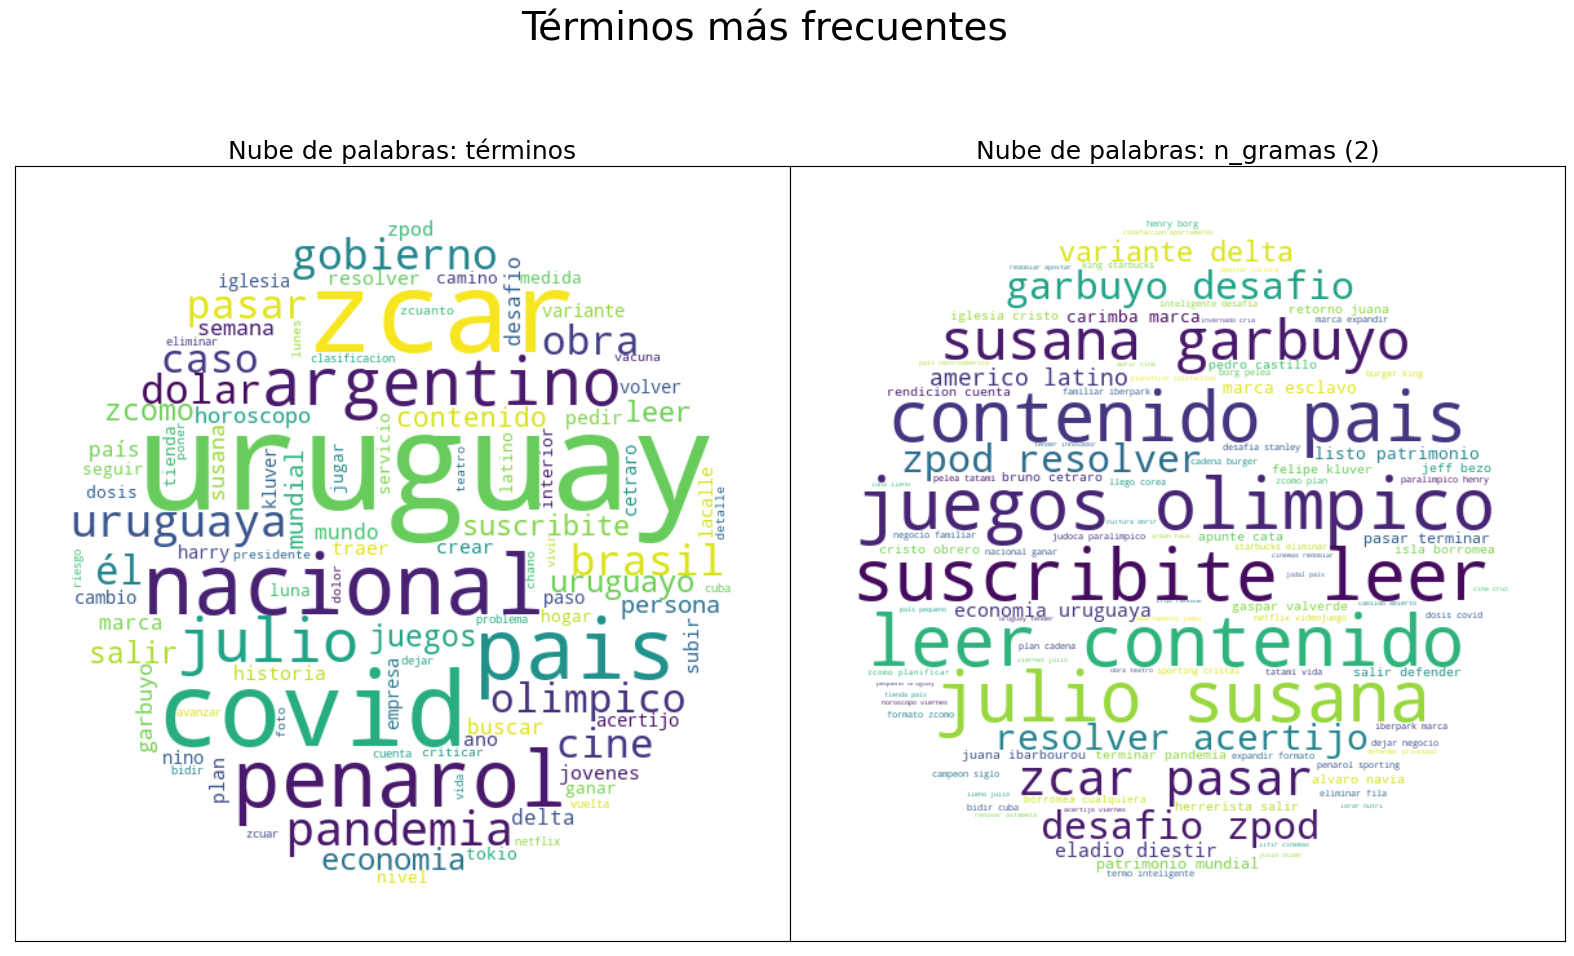

In [54]:
par_nubes(token_elpais, n1=1, n2=2, ubicacion_archivo='nube_uni_bi_elpais.jpg')

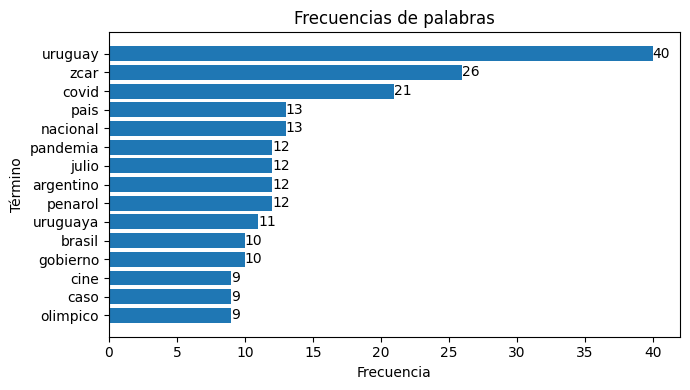

In [55]:
grafica_barchart_frecuencias(token_elpais, ubicacion_archivo='barras_palabras_elpais.jpg', 
                             titulo='Frecuencias de palabras', dim_figura=(7,4))

In [56]:
pyLDAvis.display(lda_display_elpais)

De acá para adelante considero el día como documento para hacer LDA

In [57]:
#base_elobse = base_periodo[base_periodo['diario'] == 'elobse']
base_elpais


titular       fecha  diario  \
17532  "Incautan US$ 1 millón a jefe de la banda que ...  2021-07-23  elpais   
17533  "Tercera dosis contra el COVID-19: expertos si...  2021-07-23  elpais   
17534  "żCuándo juega Peńarol contra Sporting Cristal...  2021-07-23  elpais   
17535  "Minuto a minuto: seguí la inauguración de los...  2021-07-23  elpais   
17536  "Juegos Olímpicos: así vivieron los atletas de...  2021-07-23  elpais   
...                                                  ...         ...     ...   
18063  "żCómo es \"Jungle Cruise\", lo nuevo de Disne...  2021-07-30  elpais   
18064  "Periodista revela un fuerte audio que le envi...  2021-07-30  elpais   
18065  "Celso Cuadro fue cubierto por impactante ola ...  2021-07-30  elpais   
18066  "Cabrera, \"Carroceros\" y \"Bakunin sauna\", ...  2021-07-30  elpais   
18067  "Scarlett Johansson demandó a Disney por estre...  2021-07-30  elpais   

      sentimiento                                     tit_tokenizado  
17532         NEU  [incautar, millon, jefe, banda, vendiar, titul...  
17533         NEG  [dosis, covid, experto, evidencia, impacto, co...  
17534         NEU  [zcuar, jugar, penarol, sporting, cristal, cam...  
17535         NEU  [minuto, minuto, segui, inauguracion, juegos, ...  
17536         POS  [juegos, olimpico, vivir, atleta, uruguay, cer...  
...           ...                                                ...  
18063         NEU  [zcomo, jungle, cruise, disney, rock, emily, b...  
18064         NEU  [periodista, revelar, fuerte, audio, envio, ch...  
18065         NEU  [celso, cuadro, cubierto, impactante, espuma, ...  
18066         POS  [cabrera, carrocero, bakunin, sauna, plan, sem...  
18067         NEU  [scarlett, johansson, demar, disney, estrenar,...  

[536 rows x 5 columns]

In [ ]:
Lista = []
for i in fecha_unica:
  data = base_elpais.loc[base_elpais['fecha'] == i]
  tok =list(data['tit_tokenizado'])
  Lista.append(tok)

Lista

In [59]:
frame_tok = pd.DataFrame()

frame_tok['Fechas'] = fecha_unica
frame_tok['Token'] = Lista
#frame_tok

In [60]:
frame_list = frame_tok['Token'].apply(lambda x: list(itertools.chain(*x)))


In [61]:
elpais_frame_fechas = pd.DataFrame()
elpais_frame_fechas['Fecha'] = fecha_unica
elpais_frame_fechas['Tokens'] = frame_list

tokenizado_elpais_fechas = list(elpais_frame_fechas['Tokens'])
#tokenizado_elpais_fechas

In [62]:
dictionary_elpais_tok = corpora.Dictionary(tokenizado_elpais_fechas)
dictionary_elpais_tok.filter_extremes(no_below=3)# tenía esto y lo saqué: , keep_n=300
corpus_elpais_tok = [dictionary_elpais_tok.doc2bow(text) for text in tokenizado_elpais_fechas]

In [63]:
# Esto es para seleccionar la cantidad de tópicos

results = []

for t in range(2, 10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus_elpais_tok, id2word=dictionary_elpais_tok, num_topics=t, passes=10)
    corpus_lda = lda_model[corpus_elpais_tok]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, texts=tokenizado_elpais_fechas, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [64]:
results

topic     score
0      2  0.359486
1      3  0.335059
2      4  0.323600
3      5  0.316169
4      6  0.332009
5      7  0.303494
6      8  0.310032
7      9  0.312369

In [65]:
# Define the LDA model
ldamodel_elpais = gensim.models.ldamodel.LdaModel(corpus_elpais_tok, num_topics=4, id2word=dictionary_elpais_tok, passes=10)# revisar los argumentos

# Save the topics and top 5 words
topics = ldamodel_elpais.print_topics(num_words=10)

# Print the results
#lista_topic = []
for topic in topics:
    print(topic)
    #lista_topic.append(topic)

#lista_topic = pd.DataFrame(lista_topic)
#lista_topic.to_csv("topic_elpais_2.csv")

#files.download('topic_elpais_2.csv')

(0, '0.024*"kluver" + 0.023*"crear" + 0.018*"detalle" + 0.018*"zcuanto" + 0.017*"prision" + 0.017*"caida" + 0.013*"medida" + 0.013*"dejar" + 0.013*"hablar" + 0.013*"cambiar"')
(1, '0.032*"olimpico" + 0.031*"juegos" + 0.021*"criticar" + 0.017*"buscar" + 0.017*"dolor" + 0.014*"poner" + 0.014*"lunes" + 0.013*"foto" + 0.013*"mantener" + 0.013*"camino"')
(2, '0.019*"variante" + 0.019*"delta" + 0.019*"historia" + 0.018*"país" + 0.016*"terminar" + 0.016*"mujer" + 0.016*"cruz" + 0.015*"ano" + 0.012*"pelicular" + 0.012*"cambio"')
(3, '0.031*"nino" + 0.029*"seguir" + 0.029*"empresa" + 0.028*"paso" + 0.022*"tienda" + 0.017*"eladio" + 0.016*"diestir" + 0.015*"foto" + 0.015*"zpor" + 0.015*"rodriguez"')


In [66]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_elpais.log_perplexity(corpus_elpais_tok))  # a measure of how good the model is. lower the better.



Perplexity:  -5.582711645703034


In [67]:
lda_display_elpais = pyLDAvis.gensim.prepare(ldamodel_elpais, corpus_elpais_tok, dictionary_elpais_tok, sort_topics=False, R=10)
pyLDAvis.display(lda_display_elpais)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


AHORA CON LA DIARIA

In [68]:
base_ladiar = base_periodo[base_periodo['diario'] == 'ladiar']

tokenizado_ladiar = list(base_ladiar['tit_tokenizado'])

In [69]:
# flattening the list and storing the result
flat_list = itertools.chain(*tokenizado_ladiar)
# converting iterable to list and printing
#tok = print(list(flat_list))
#flat_list
tok = list(flat_list)
token_ladiar = " ".join(map(str, tok))
token_ladiar

'crecer choque coalicion aprobar él fideicomiso canelón acusación presion politiqueria juegos olimpico tokio calendario competencia deporte encuentro penarol elimino nacional paso cuarto sudamericano global visitante estrategia ministerio interior evaluar él rendicion cuenta plantear meta cumplir plenario centro partido miranda  futuro conduccion partido sindicato ensenanza entrar proceso discusion recuperar cargo docente codecir estafa pastor evangelico colonia vendiar titulo falso extranjero logo unesco incautar bien millon dolar gobierno chino rechazo investigacion territorio determinar origen pandemia covid rucvds exhortar gobierno subsanar atraso pago equipo tecnico servicio violencia genero resolver faltar solución habitacional zcar virus albergar murcielago uruguayo ensenar contexto pandemia marós giorgio encantar mundo apunte firma apunte entretelón canelón apunte periodismo cabildo abierto apunte gobernando atropellado laurel hubbard atleta transgenero juegos olimpico futbol f

In [70]:
unigramas = obtener_ngramas(token_ladiar, 1)
bigramas = obtener_ngramas(token_ladiar, 2)

Acá el código para LDA, luego vendrán todos los gráficos juntos

In [71]:
dictionary_ladiar = corpora.Dictionary(tokenizado_ladiar)
dictionary_ladiar.filter_extremes(no_below=3)# tenía esto y lo saqué: , keep_n=300

corpus_ladiar = [dictionary_ladiar.doc2bow(text) for text in tokenizado_ladiar]

In [72]:
# Esto es para seleccionar la cantidad de tópicos

results = []

for t in range(2, 10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus_ladiar, id2word=dictionary_ladiar, num_topics=t, passes=10)
    corpus_lda = lda_model[corpus_ladiar]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, texts=tokenizado_ladiar, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [73]:
results

topic     score
0      2  0.693553
1      3  0.659958
2      4  0.611796
3      5  0.549667
4      6  0.528226
5      7  0.499166
6      8  0.458516
7      9  0.488944

In [74]:
# Define the LDA model
ldamodel_ladiar = gensim.models.ldamodel.LdaModel(corpus_ladiar, num_topics=4, id2word=dictionary_ladiar, passes=10)# revisar los argumentos

# Save the topics and top 5 words
topics = ldamodel_ladiar.print_topics(num_words=10)

# Print the results
#lista_topic = []
for topic in topics:
    print(topic)
    #lista_topic.append(topic)

#lista_topic = pd.DataFrame(lista_topic)
#lista_topic.to_csv("topic_ladiar_1.csv")

#files.download('topic_ladiar_1.csv')

(0, '0.011*"mujer" + 0.010*"tacuarembo" + 0.010*"venir" + 0.010*"estatal" + 0.010*"ano" + 0.010*"covid" + 0.009*"rendicion" + 0.009*"cuenta" + 0.009*"muerte" + 0.009*"gobierno"')
(1, '0.025*"pandemia" + 0.018*"cuenta" + 0.016*"tiempo" + 0.015*"rendicion" + 0.014*"uruguayo" + 0.013*"persona" + 0.012*"trabajador" + 0.011*"gobierno" + 0.010*"documento" + 0.010*"albergar"')
(2, '0.018*"apunte" + 0.010*"uruguay" + 0.010*"construir" + 0.010*"obra" + 0.009*"advertir" + 0.009*"juegos" + 0.009*"colorado" + 0.009*"olimpico" + 0.009*"monumento" + 0.009*"mano"')
(3, '0.030*"gigante" + 0.030*"numero" + 0.025*"olimpico" + 0.020*"juegos" + 0.016*"dedicado" + 0.015*"pandemia" + 0.013*"tiempo" + 0.011*"kluver" + 0.011*"ministro" + 0.010*"igualdad"')


In [75]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_ladiar.log_perplexity(corpus_ladiar))  # a measure of how good the model is. lower the better.



Perplexity:  -6.264451106355489


In [76]:
lda_display_ladiar = pyLDAvis.gensim.prepare(ldamodel_ladiar, corpus_ladiar, dictionary_ladiar, sort_topics=False, R=10)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


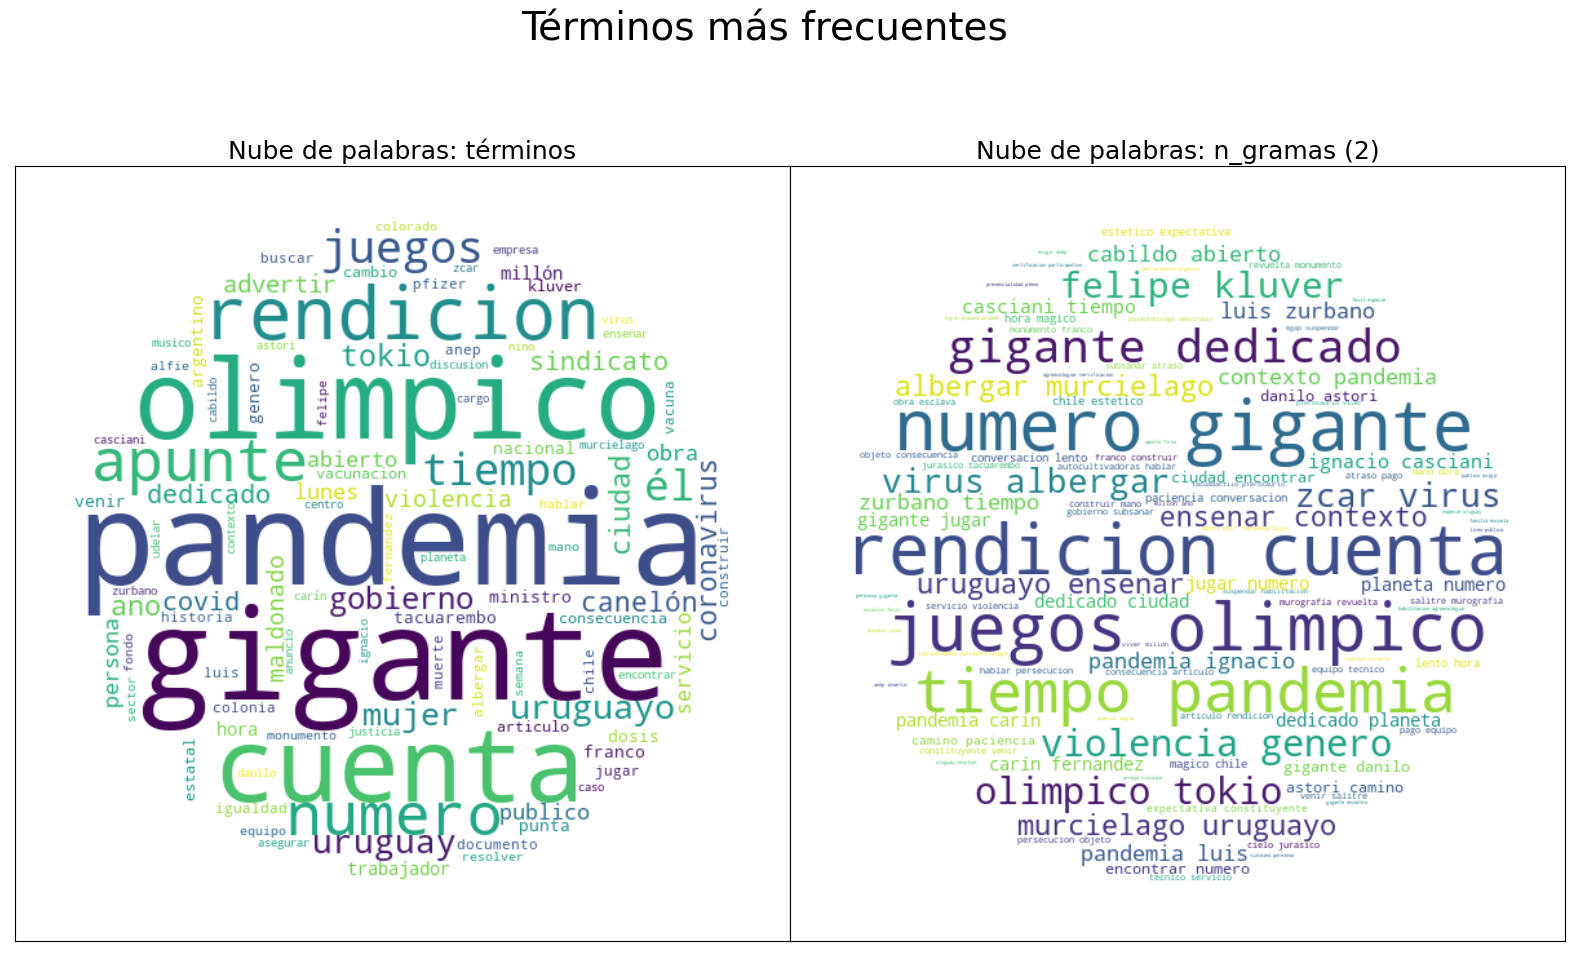

In [77]:
par_nubes(token_ladiar, n1=1, n2=2, ubicacion_archivo='nube_uni_bi_ladiar.jpg')

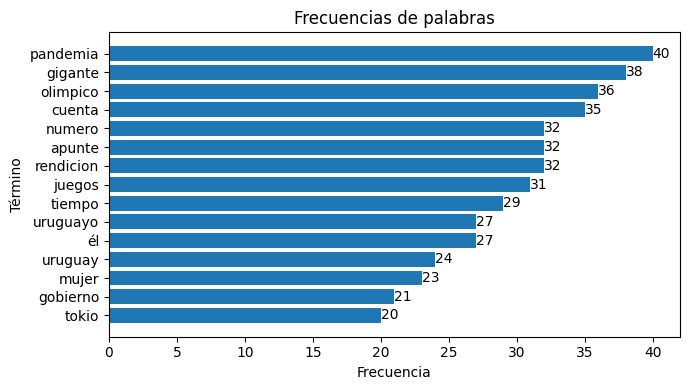

In [78]:
grafica_barchart_frecuencias(token_ladiar, ubicacion_archivo='barras_palabras_ladiar.jpg', 
                             titulo='Frecuencias de palabras', dim_figura=(7,4))

In [79]:
pyLDAvis.display(lda_display_ladiar)

De acá para adelante considero el día como documento para hacer LDA

In [80]:
Lista = []
for i in fecha_unica:
  data = base_ladiar.loc[base_ladiar['fecha'] == i]
  tok =list(data['tit_tokenizado'])
  Lista.append(tok)

#Lista

In [81]:
frame_tok = pd.DataFrame()

frame_tok['Fechas'] = fecha_unica
frame_tok['Token'] = Lista

In [82]:
frame_list = frame_tok['Token'].apply(lambda x: list(itertools.chain(*x)))

In [83]:
ladiar_frame_fechas = pd.DataFrame()
ladiar_frame_fechas['Fecha'] = fecha_unica
ladiar_frame_fechas['Tokens'] = frame_list

tokenizado_ladiar_fechas = list(ladiar_frame_fechas['Tokens'])

In [84]:
dictionary_ladiar_tok = corpora.Dictionary(tokenizado_ladiar_fechas)
dictionary_ladiar_tok.filter_extremes(no_below=3)# tenía esto y lo saqué: , keep_n=300
corpus_ladiar_tok = [dictionary_ladiar_tok.doc2bow(text) for text in tokenizado_ladiar_fechas]

In [85]:
# Esto es para seleccionar la cantidad de tópicos

results = []

for t in range(2, 10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus_ladiar_tok, id2word=dictionary_ladiar_tok, num_topics=t, passes=10)
    corpus_lda = lda_model[corpus_ladiar_tok]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, texts=tokenizado_ladiar_fechas, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [86]:
results

topic     score
0      2  0.318236
1      3  0.371599
2      4  0.392188
3      5  0.349829
4      6  0.342584
5      7  0.388136
6      8  0.384344
7      9  0.407856

In [91]:
# Define the LDA model
ldamodel_ladiar = gensim.models.ldamodel.LdaModel(corpus_ladiar_tok, num_topics=9, id2word=dictionary_ladiar_tok, passes=10)# revisar los argumentos

# Save the topics and top 5 words
topics = ldamodel_ladiar.print_topics(num_words=10)

# Print the results
#lista_topic = []
for topic in topics:
    print(topic)
    #lista_topic.append(topic)

#lista_topic = pd.DataFrame(lista_topic)
#lista_topic.to_csv("topic_ladiar_2.csv")

#files.download('topic_ladiar_2.csv')

(0, '0.021*"historia" + 0.014*"barrio" + 0.010*"coordinador" + 0.010*"ehrlich" + 0.009*"quedar" + 0.008*"unico" + 0.008*"cuerpo" + 0.008*"cancer" + 0.008*"olla" + 0.008*"sentir yo"')
(1, '0.003*"publicar" + 0.003*"proyecto" + 0.003*"comenzar" + 0.003*"climatico" + 0.003*"medida" + 0.003*"teatro" + 0.003*"final" + 0.003*"iglesia" + 0.003*"informe" + 0.003*"terminar"')
(2, '0.019*"faltar" + 0.014*"pedir" + 0.012*"debutar" + 0.011*"laboral" + 0.011*"desarrollo" + 0.011*"politico" + 0.011*"representante" + 0.010*"controlar" + 0.010*"comida" + 0.010*"orden"')
(3, '0.014*"causar" + 0.014*"climatico" + 0.014*"publicar" + 0.014*"proyecto" + 0.012*"reforma" + 0.012*"metro" + 0.012*"iglesia" + 0.012*"informe" + 0.012*"final" + 0.012*"medida"')
(4, '0.019*"libro" + 0.019*"subsidio" + 0.017*"oficialismo" + 0.014*"superga" + 0.014*"policial" + 0.014*"dolor" + 0.014*"defensor" + 0.014*"oficio" + 0.011*"barrio" + 0.011*"reclamar"')
(5, '0.003*"historia" + 0.003*"barrio" + 0.003*"comida" + 0.003*"musi

In [92]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_ladiar.log_perplexity(corpus_ladiar_tok))  # a measure of how good the model is. lower the better.



Perplexity:  -6.2574006216718425


In [93]:
lda_display_ladiar = pyLDAvis.gensim.prepare(ldamodel_ladiar, corpus_ladiar_tok, dictionary_ladiar_tok, sort_topics=False, R=10)
pyLDAvis.display(lda_display_ladiar)

AHORA CON MONTEVIDEO.COM

In [90]:
base_montev = base_periodo[base_periodo['diario'] == 'montev']

tokenizado_montev = list(base_montev['tit_tokenizado'])

In [94]:
# flattening the list and storing the result
flat_list = itertools.chain(*tokenizado_montev)
# converting iterable to list and printing
#tok = print(list(flat_list))
#flat_list
tok = list(flat_list)
token_montev = " ".join(map(str, tok))
token_montev

'efecto rebano lograr uruguay dificultad bajo vacunacion regional clasico festejo penarol red vestuario eliminar nacional clasico mensaje ignacio ruglio clasificacion aurinegra frente nacional tokio marchar desfile inaugural juegos olimpico niffouri fideicomiso habio millón sabiar ir documental buitre disponible sala virtual ano prision hombre reiterado abuso sexual menor orgulloso hacer giovanni gonzalez eliminar nacional clasico galeria clasificacion penarol sudamericano frente nacional mes nieripeso criptomoneda uruguaya buscar sistema fernandar tria miedo visitar parte oscuro corazon humano junta dtal condeno bloqueo cuba reivindicar derecho manifestación pacifica rendicion cuenta familiar policia perderiar cobertura hospital policial hombre acribillado tiro bordo auto rivero penarol obligacion clasificar hacer merito mauricio larriera responsabilidad afectivo amor consciente mes inactividad celebrar reapertura cine taller innovacion mecanico robotico programacion nino lynch gobern

In [ ]:
unigramas = obtener_ngramas(token_montev, 1)
bigramas = obtener_ngramas(token_montev, 2)

Acá el código para LDA, luego vendrán todos los gráficos juntos

In [95]:
dictionary_montev = corpora.Dictionary(tokenizado_montev)
dictionary_montev.filter_extremes(no_below=3)# tenía esto y lo saqué: , keep_n=300

corpus_montev = [dictionary_montev.doc2bow(text) for text in tokenizado_montev]

In [96]:
# Esto es para seleccionar la cantidad de tópicos

results = []

for t in range(2, 10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus_montev, id2word=dictionary_montev, num_topics=t, passes=10)
    corpus_lda = lda_model[corpus_montev]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, texts=tokenizado_montev, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [97]:
results

topic     score
0      2  0.666664
1      3  0.653504
2      4  0.656069
3      5  0.619620
4      6  0.527651
5      7  0.552169
6      8  0.540232
7      9  0.524486

In [98]:
# Define the LDA model
ldamodel_montev = gensim.models.ldamodel.LdaModel(corpus_montev, num_topics=3, id2word=dictionary_montev, passes=10)# revisar los argumentos

# Save the topics and top 5 words
topics = ldamodel_montev.print_topics(num_words=10)

# Print the results
#lista_topic = []
for topic in topics:
    print(topic)
    #lista_topic.append(topic)

#lista_topic = pd.DataFrame(lista_topic)
#lista_topic.to_csv("topic_montev_1.csv")

#files.download('topic_montev_1.csv')

(0, '0.033*"tokio" + 0.019*"nacional" + 0.016*"penarol" + 0.014*"luna" + 0.013*"brasil" + 0.012*"argentino" + 0.011*"juego" + 0.011*"fijar" + 0.011*"hombre" + 0.010*"humanidad"')
(1, '0.022*"pedir" + 0.020*"eeuu" + 0.017*"apertura" + 0.017*"ganar" + 0.015*"salto" + 0.014*"red" + 0.013*"interior" + 0.011*"plaza" + 0.011*"novillo" + 0.011*"policia"')
(2, '0.036*"opinion" + 0.032*"uruguay" + 0.016*"cuba" + 0.015*"covid" + 0.015*"uruguayo" + 0.015*"caso" + 0.014*"juegos" + 0.013*"olimpico" + 0.013*"ano" + 0.013*"millón"')


In [99]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_montev.log_perplexity(corpus_montev))  # a measure of how good the model is. lower the better.



Perplexity:  -6.053309423091284


In [100]:
lda_display_montev = pyLDAvis.gensim.prepare(ldamodel_montev, corpus_montev, dictionary_montev, sort_topics=False, R=10)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


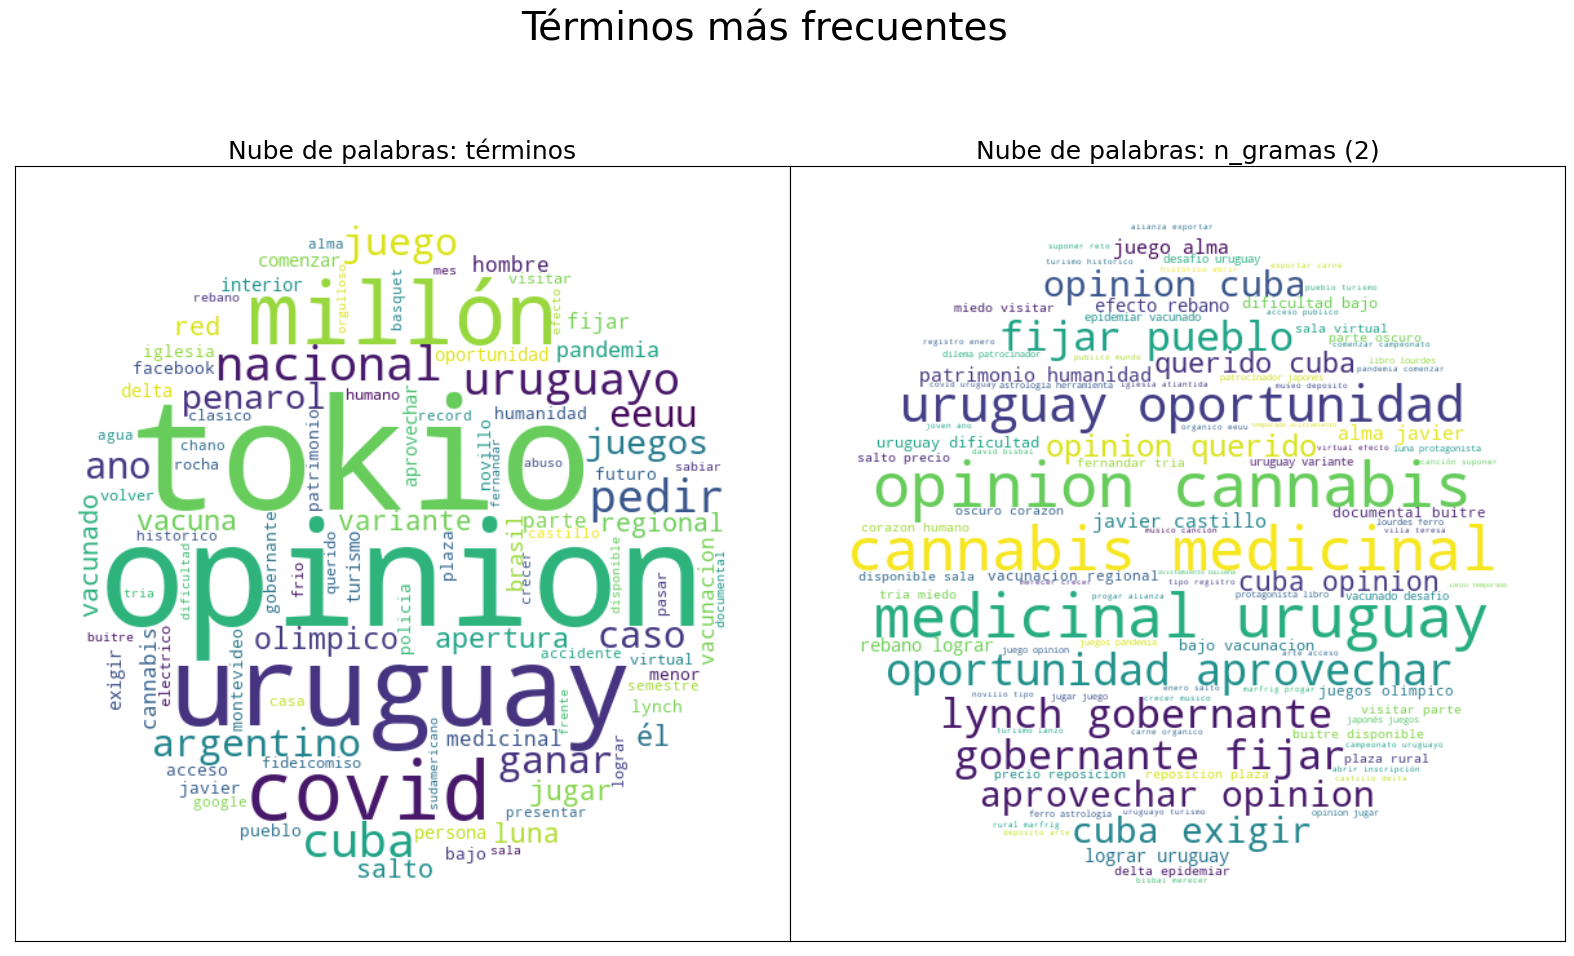

In [101]:
par_nubes(token_montev, n1=1, n2=2, ubicacion_archivo='nube_uni_bi_montev.jpg')

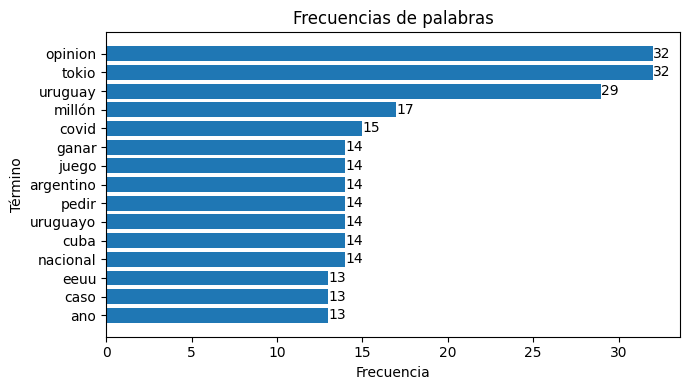

In [102]:
grafica_barchart_frecuencias(token_montev, ubicacion_archivo='barras_palabras_montev.jpg', 
                             titulo='Frecuencias de palabras', dim_figura=(7,4))

In [103]:
pyLDAvis.display(lda_display_montev)

De acá para adelante considero el día como documento para hacer LDA



In [104]:
Lista = []
for i in fecha_unica:
  data = base_montev.loc[base_montev['fecha'] == i]
  tok =list(data['tit_tokenizado'])
  Lista.append(tok)

#Lista

In [105]:
frame_tok = pd.DataFrame()

frame_tok['Fechas'] = fecha_unica
frame_tok['Token'] = Lista

In [106]:
frame_list = frame_tok['Token'].apply(lambda x: list(itertools.chain(*x)))

In [107]:
montev_frame_fechas = pd.DataFrame()
montev_frame_fechas['Fecha'] = fecha_unica
montev_frame_fechas['Tokens'] = frame_list

tokenizado_montev_fechas = list(montev_frame_fechas['Tokens'])

In [108]:
dictionary_montev_tok = corpora.Dictionary(tokenizado_montev_fechas)
dictionary_montev_tok.filter_extremes(no_below=3)# tenía esto y lo saqué: , keep_n=300
corpus_montev_tok = [dictionary_montev_tok.doc2bow(text) for text in tokenizado_montev_fechas]

In [109]:
# Esto es para seleccionar la cantidad de tópicos

results = []

for t in range(2, 10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus_montev_tok, id2word=dictionary_montev_tok, num_topics=t, passes=10)
    corpus_lda = lda_model[corpus_montev_tok]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, texts=tokenizado_montev_fechas, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [110]:
results

topic     score
0      2  0.334474
1      3  0.304935
2      4  0.346388
3      5  0.346103
4      6  0.350867
5      7  0.286283
6      8  0.335882
7      9  0.306726

In [117]:
# Define the LDA model
ldamodel_montev = gensim.models.ldamodel.LdaModel(corpus_montev_tok, num_topics=5, id2word=dictionary_montev_tok, passes=10)# revisar los argumentos

# Save the topics and top 5 words
topics = ldamodel_montev.print_topics(num_words=10)

# Print the results
#lista_topic = []
for topic in topics:
    print(topic)
    #lista_topic.append(topic)

#lista_topic = pd.DataFrame(lista_topic)
#lista_topic.to_csv("topic_montev_2.csv")

#files.download('topic_montev_2.csv')

(0, '0.014*"comenzar" + 0.013*"brasil" + 0.012*"copa" + 0.010*"basquet" + 0.010*"velar" + 0.010*"puerto" + 0.010*"homenaje" + 0.010*"cumplir" + 0.010*"fideicomiso" + 0.010*"hijo"')
(1, '0.004*"fideicomiso" + 0.004*"homenaje" + 0.004*"comenzar" + 0.004*"puerto" + 0.004*"velar" + 0.004*"mes" + 0.004*"semana" + 0.004*"pez" + 0.004*"empatar" + 0.004*"daimler"')
(2, '0.019*"agua" + 0.016*"policia" + 0.016*"llegar" + 0.016*"google" + 0.013*"chano" + 0.013*"sufrio" + 0.013*"barcelona" + 0.013*"abuso" + 0.012*"mundo" + 0.011*"david"')
(3, '0.017*"dosis" + 0.014*"diestir" + 0.014*"presidente" + 0.013*"murio" + 0.013*"espana" + 0.013*"ganancia" + 0.013*"elevar" + 0.013*"record" + 0.013*"maldonado" + 0.013*"publico"')
(4, '0.027*"clasico" + 0.021*"hombre" + 0.014*"domingo" + 0.014*"frente" + 0.014*"celebrar" + 0.014*"empatar" + 0.014*"presentar" + 0.014*"mes" + 0.014*"disco" + 0.014*"fideicomiso"')


In [118]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_montev.log_perplexity(corpus_montev_tok))  # a measure of how good the model is. lower the better.



Perplexity:  -5.945899843456952


In [119]:
lda_display_montev = pyLDAvis.gensim.prepare(ldamodel_montev, corpus_montev_tok, dictionary_montev_tok, sort_topics=False, R=10)
pyLDAvis.display(lda_display_montev)

AHORA CON LA REPUBLICA

In [120]:
base_republ = base_periodo[base_periodo['diario'] == 'republ']

tokenizado_republ = list(base_republ['tit_tokenizado'])

In [121]:
# flattening the list and storing the result
flat_list = itertools.chain(*tokenizado_republ)
# converting iterable to list and printing
#tok = print(list(flat_list))
#flat_list
tok = list(flat_list)
token_republ = " ".join(map(str, tok))
token_republ

'olesker testa politico salarial perjudicar clase trabajadorat empezo ceremonia inaugural juegos olimpico tokio operativo clasico termino detenido madrugada gobierno analizar cerrar fila defender tuán proyecto tenencia compartido tponir riesgo infanciat ciudadano votar ente depositar banca privado definir dosis poblacion proximo semana caso activo coronavirus ubicar bauzo confirmar retorno publico estadio agosto couto frente amplio pleno proceso reacomodot historia actualidad puerto dolor cementerio barco abandonado puerto montevideo despues ano penarol volver jugar cuarto final copa importancia microbiotar intestinal cabildo abierto presentar proyecto combatir ciberdelito fiesta aurinegra pese perder penarol clasifico afuero nacional panorama supuesto implicado comuna noticia cualquiera carnaval futuro amarguear deporte loco tema teatro verde chicán alma guarani industria turf estacion ajedrez uruguay desfilo ceremonia juegos olimpico pabellon alto cappuccio pedir disculpa hincha hace

In [122]:
unigramas = obtener_ngramas(token_republ, 1)
bigramas = obtener_ngramas(token_republ, 2)

Acá el código para LDA, luego vendrán todos los gráficos juntos

In [123]:
dictionary_republ = corpora.Dictionary(tokenizado_republ)
dictionary_republ.filter_extremes(no_below=3)# tenía esto y lo saqué: , keep_n=300

corpus_republ = [dictionary_republ.doc2bow(text) for text in tokenizado_republ]

In [124]:
# Esto es para seleccionar la cantidad de tópicos

results = []

for t in range(2, 10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus_republ, id2word=dictionary_republ, num_topics=t, passes=10)
    corpus_lda = lda_model[corpus_republ]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, texts=tokenizado_republ, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [125]:
results

topic     score
0      2  0.774542
1      3  0.653144
2      4  0.620793
3      5  0.622897
4      6  0.612440
5      7  0.621193
6      8  0.621488
7      9  0.604694

In [127]:
# Define the LDA model
ldamodel_republ = gensim.models.ldamodel.LdaModel(corpus_republ, num_topics=3, id2word=dictionary_republ, passes=10)# revisar los argumentos

# Save the topics and top 5 words
topics = ldamodel_republ.print_topics(num_words=10)

# Print the results
#lista_topic = []
for topic in topics:
    print(topic)
    #lista_topic.append(topic)

#lista_topic = pd.DataFrame(lista_topic)
#lista_topic.to_csv("topic_republ_1.csv")

#files.download('topic_republ_1.csv')

(0, '0.029*"ente" + 0.029*"realizar" + 0.029*"paro" + 0.029*"sindical" + 0.029*"deporte" + 0.026*"mujer" + 0.026*"afro" + 0.026*"julio" + 0.026*"comuna" + 0.026*"noticia"')
(1, '0.036*"nacional" + 0.033*"futuro" + 0.030*"educativo" + 0.030*"gobierno" + 0.027*"carnaval" + 0.027*"alma" + 0.027*"guarani" + 0.027*"teatro" + 0.027*"turf" + 0.027*"industria"')
(2, '0.033*"uruguay" + 0.024*"tema" + 0.024*"ajedrez" + 0.024*"estacion" + 0.024*"loco" + 0.024*"amarguear" + 0.024*"supuesto" + 0.024*"implicado" + 0.024*"verde" + 0.024*"pandemia"')


In [129]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_republ.log_perplexity(corpus_republ))  # a measure of how good the model is. lower the better.



Perplexity:  -5.310417507805709


In [130]:
lda_display_republ = pyLDAvis.gensim.prepare(ldamodel_republ, corpus_republ, dictionary_republ, sort_topics=False, R=10)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


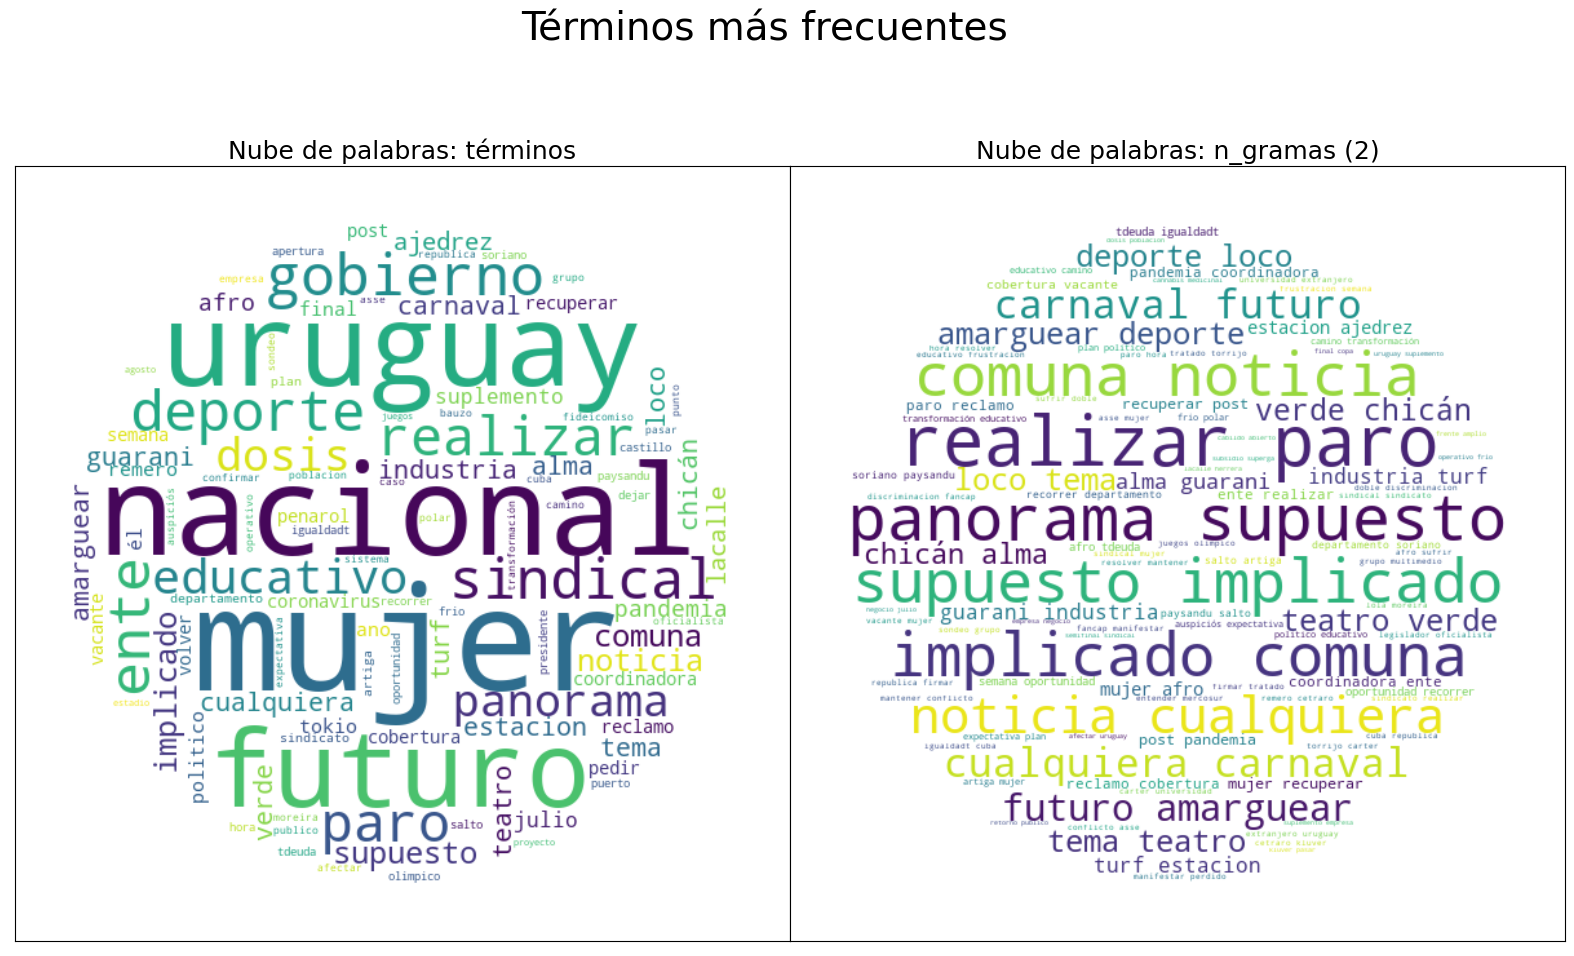

In [131]:
par_nubes(token_republ, n1=1, n2=2, ubicacion_archivo='nube_uni_bi_republ.jpg')

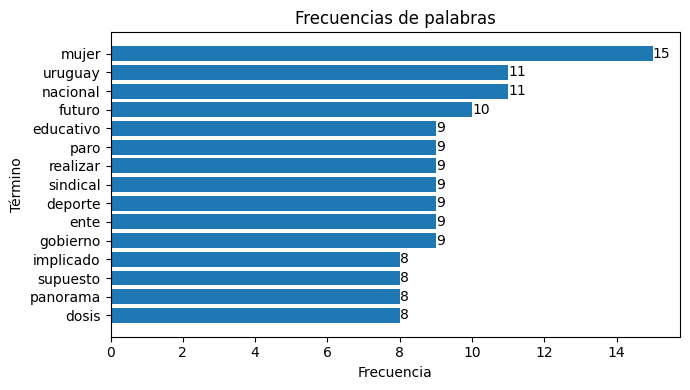

In [132]:
grafica_barchart_frecuencias(token_republ, ubicacion_archivo='barras_palabras_republ.jpg', 
                             titulo='Frecuencias de palabras', dim_figura=(7,4))

In [133]:
pyLDAvis.display(lda_display_republ)

De acá para adelante considero el día como documento para hacer LDA



In [134]:
Lista = []
for i in fecha_unica:
  data = base_republ.loc[base_republ['fecha'] == i]
  tok =list(data['tit_tokenizado'])
  Lista.append(tok)

#Lista

In [135]:
frame_tok = pd.DataFrame()

frame_tok['Fechas'] = fecha_unica
frame_tok['Token'] = Lista

In [136]:
frame_list = frame_tok['Token'].apply(lambda x: list(itertools.chain(*x)))

In [137]:
republ_frame_fechas = pd.DataFrame()
republ_frame_fechas['Fecha'] = fecha_unica
republ_frame_fechas['Tokens'] = frame_list

tokenizado_republ_fechas = list(republ_frame_fechas['Tokens'])

In [138]:
dictionary_republ_tok = corpora.Dictionary(tokenizado_republ_fechas)
dictionary_republ_tok.filter_extremes(no_below=3)# tenía esto y lo saqué: , keep_n=300
corpus_republ_tok = [dictionary_republ_tok.doc2bow(text) for text in tokenizado_republ_fechas]

In [139]:
# Esto es para seleccionar la cantidad de tópicos

results = []

for t in range(2, 10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus_republ_tok, id2word=dictionary_republ_tok, num_topics=t, passes=10)
    corpus_lda = lda_model[corpus_republ_tok]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, texts=tokenizado_republ_fechas, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [140]:
results

topic     score
0      2  0.373903
1      3  0.391299
2      4  0.377967
3      5  0.452506
4      6  0.364948
5      7  0.459931
6      8  0.380917
7      9  0.374761

In [153]:
# Define the LDA model
ldamodel_republ = gensim.models.ldamodel.LdaModel(corpus_republ_tok, num_topics=5, id2word=dictionary_republ_tok, passes=10)# revisar los argumentos

# Save the topics and top 5 words
topics = ldamodel_republ.print_topics(num_words=10)

# Print the results
#lista_topic = []
for topic in topics:
    print(topic)
    #lista_topic.append(topic)

#lista_topic = pd.DataFrame(lista_topic)
#lista_topic.to_csv("topic_republ_2.csv")

#files.download('topic_republ_2.csv')

(0, '0.035*"polar" + 0.035*"frio" + 0.035*"auspiciós" + 0.035*"camino" + 0.035*"expectativa" + 0.035*"transformación" + 0.032*"plan" + 0.032*"grupo" + 0.032*"oficialista" + 0.023*"cetraro"')
(1, '0.034*"plan" + 0.031*"moreira" + 0.031*"punto" + 0.031*"mid" + 0.031*"pasar" + 0.031*"superga" + 0.025*"asse" + 0.022*"fideicomiso" + 0.022*"republica" + 0.022*"semifinal"')
(2, '0.053*"pedir" + 0.043*"dejar" + 0.033*"bauzo" + 0.033*"confirmar" + 0.033*"empresa" + 0.033*"pfizer" + 0.025*"castillo" + 0.022*"fideicomiso" + 0.022*"agosto" + 0.022*"pleno"')
(3, '0.013*"dejar" + 0.013*"castillo" + 0.013*"multimedio" + 0.013*"afectar" + 0.013*"union" + 0.013*"auspiciós" + 0.013*"colonia" + 0.013*"camino" + 0.013*"ministro" + 0.013*"legislador"')
(4, '0.030*"afectar" + 0.030*"frio" + 0.030*"frente" + 0.030*"cuba" + 0.030*"carter" + 0.030*"firmar" + 0.030*"manifestar" + 0.030*"extranjero" + 0.030*"doble" + 0.030*"perdido"')


In [154]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_republ.log_perplexity(corpus_republ_tok))  # a measure of how good the model is. lower the better.



Perplexity:  -5.0383519581834175


In [155]:
lda_display_republ = pyLDAvis.gensim.prepare(ldamodel_republ, corpus_republ_tok, dictionary_republ_tok, sort_topics=False, R=10)
pyLDAvis.display(lda_display_republ)

In [157]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [158]:
#base = pd.read_csv('base_tit_senti_fecha.csv', encoding='iso8859_2')
#base_periodo = base[(base['fecha'] <= '2021-07-30') & (base['fecha'] >= '2021-07-23')]

In [159]:
print('\n''Número de títulos por diario en el rango de fechas seleccionadas: 2021-07-23 - 2021-07-30')
print('--------------------------')

base_periodo.groupby(by='diario')['titular'].count() # El número de titulos por diario


Número de títulos por diario en el rango de fechas seleccionadas: 2021-07-23 - 2021-07-30
--------------------------


diario
elobse    549
elpais    536
ladiar    711
montev    558
republ    404
Name: titular, dtype: int64

In [160]:
base_periodo

titular       fecha  diario  \
0      "Mirá la ceremonia de inauguración de los Jueg...  2021-07-23  elobse   
1      "El contrasentido del clásico: Peńarol perdió ...  2021-07-23  elobse   
2      "Los sueldos de $ 200.000 en el Directorio de ...  2021-07-23  elobse   
3      "żDónde se podrán ver los Juegos Olímpicos de ...  2021-07-23  elobse   
4      "Crece interés de argentinos por Montevideo: c...  2021-07-23  elobse   
...                                                  ...         ...     ...   
83764                 "El segundo Exilio"                 2021-07-30  republ   
83765  "El sondeo del Grupo R Multimedio sobre la LUC...  2021-07-30  republ   
83766  "Lacalle Pou recibe hoy a legisladores oficial...  2021-07-30  republ   
83767  "Suplemento Especial Puertos Del Uruguay"     ...  2021-07-30  republ   
83768  "Suplemento Empresa Y Negocio  30 de Julio de...  2021-07-30  republ   

      sentimiento                                     tit_tokenizado  
0             NEU                                       [, , , , , ]  
1             NEU  [contrasentido, clasico, penarol, perdar, canc...  
2             NEU  [sueldo, directorio, caja, profesional, propue...  
3             NEU         [zdonde, juegos, olimpico, tokio, uruguay]  
4             POS  [crecer, inter, argentino, montevideo, compra,...  
...           ...                                                ...  
83764         NEU                                           [exilio]  
83765         NEU                        [sondeo, grupo, multimedio]  
83766         NEU  [lacalle, recibir, legislador, oficialista, pu...  
83767         NEU            [suplemento, especial, puerto, uruguay]  
83768         NEU              [suplemento, empresa, negocio, julio]  

[2758 rows x 5 columns]

In [161]:
base_periodo_tidy = base_periodo.explode(column='tit_tokenizado')
base_periodo_tidy = base_periodo_tidy.drop(columns='titular')
base_periodo_tidy = base_periodo_tidy.rename(columns={'tit_tokenizado':'token'})


In [162]:
print('\n''Palabras totales por diario')
print('--------------------------')
base_periodo_tidy.groupby(by='diario')['token'].count()


Palabras totales por diario
--------------------------


diario
elobse    3281
elpais    3220
ladiar    4784
montev    3597
republ    1696
Name: token, dtype: int64

In [163]:
# Número de palabras comunes
# ==============================================================================
palabras_elpais = set(base_periodo_tidy[base_periodo_tidy.diario == 'elpais']['token'])
palabras_elobse = set(base_periodo_tidy[base_periodo_tidy.diario == 'elobse']['token'])
palabras_ladiar = set(base_periodo_tidy[base_periodo_tidy.diario == 'ladiar']['token'])
palabras_montev = set(base_periodo_tidy[base_periodo_tidy.diario == 'montev']['token'])
palabras_republ = set(base_periodo_tidy[base_periodo_tidy.diario == 'republ']['token'])

print(f"Palabras comunes entre elpais y elobse: {len(palabras_elpais.intersection(palabras_elobse))}")
print(f"Palabras comunes entre elpais y montev: {len(palabras_elpais.intersection(palabras_montev))}")
print(f"Palabras comunes entre elpais y ladiar: {len(palabras_elpais.intersection(palabras_ladiar))}")
print(f"Palabras comunes entre elpais y republ: {len(palabras_elpais.intersection(palabras_republ))}")
print(f"Palabras comunes entre elobse y ladiar: {len(palabras_elobse.intersection(palabras_ladiar))}")
print(f"Palabras comunes entre elobse y republ: {len(palabras_elobse.intersection(palabras_republ))}")
print(f"Palabras comunes entre elobse y montev: {len(palabras_elobse.intersection(palabras_montev))}")
print(f"Palabras comunes entre republ y montev: {len(palabras_republ.intersection(palabras_montev))}")
print(f"Palabras comunes entre republ y ladiar: {len(palabras_republ.intersection(palabras_ladiar))}")
print(f"Palabras comunes entre montev y ladiar: {len(palabras_montev.intersection(palabras_ladiar))}")

Palabras comunes entre elpais y elobse: 623
Palabras comunes entre elpais y montev: 599
Palabras comunes entre elpais y ladiar: 566
Palabras comunes entre elpais y republ: 405
Palabras comunes entre elobse y ladiar: 564
Palabras comunes entre elobse y republ: 388
Palabras comunes entre elobse y montev: 563
Palabras comunes entre republ y montev: 377
Palabras comunes entre republ y ladiar: 399
Palabras comunes entre montev y ladiar: 523


In [164]:
print('----------------------------')
print('Palabras distintas por diario')
print('----------------------------')
base_periodo_tidy.groupby(by='diario')['token'].nunique()

----------------------------
Palabras distintas por diario
----------------------------


diario
elobse    1597
elpais    1807
ladiar    1514
montev    1668
republ     913
Name: token, dtype: int64

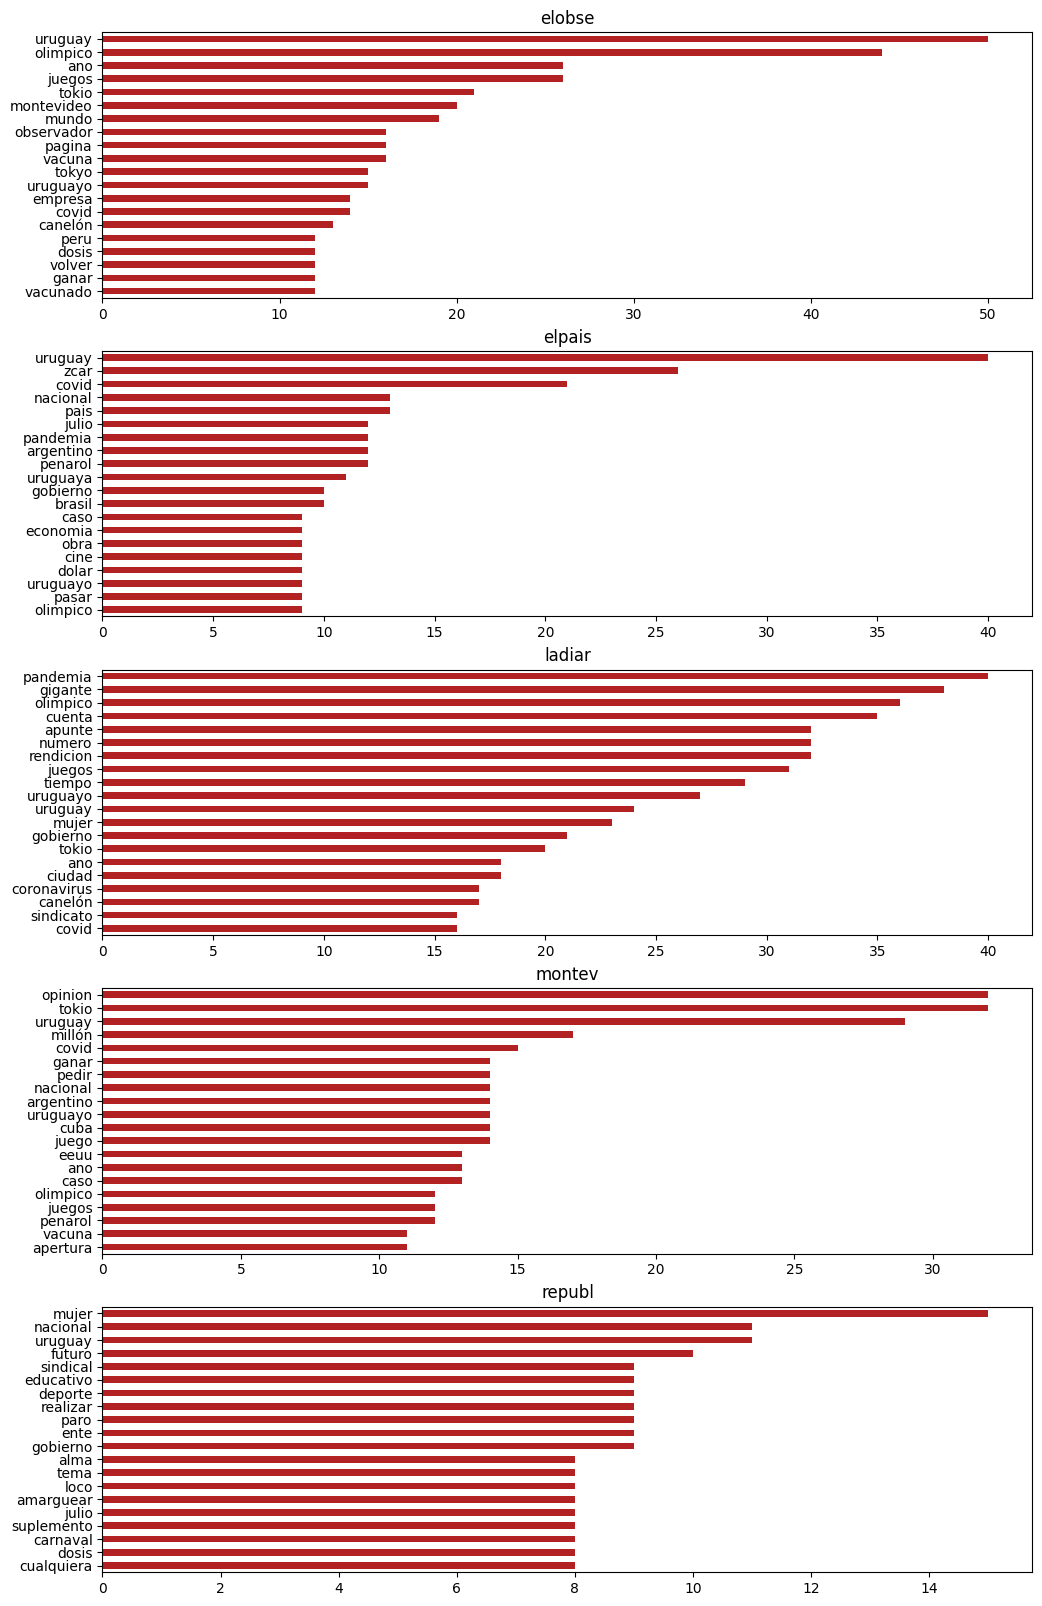

In [165]:
# Gráficos del Top 10 de las palabras por diario
# ==============================================================================
fig, axs = plt.subplots(nrows=5, ncols=1,figsize=(12, 20))
for i, diario in enumerate(base_periodo_tidy.diario.unique()):
    df_temp = base_periodo_tidy[base_periodo_tidy.diario == diario]
    counts  = df_temp['token'].value_counts(ascending=False).head(20)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(diario)
#plt.savefig("barras_palabras.jpg")

In [166]:
# Top 10 de las palabras más utilizadas por cada diario
# ==============================================================================
base_periodo_tidy.groupby(['diario','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('diario') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(10))

diario       token  count
diario                                
elobse 1503  elobse     uruguay     50
       1057  elobse    olimpico     44
       71    elobse         ano     26
       820   elobse      juegos     26
       1465  elobse       tokio     21
       976   elobse  montevideo     20
       995   elobse       mundo     19
       1039  elobse  observador     16
       1087  elobse      pagina     16
       1512  elobse      vacuna     16
elpais 3312  elpais     uruguay     40
       3386  elpais        zcar     26
       2018  elpais       covid     21
       2830  elpais        pais     13
       2745  elpais    nacional     13
       2550  elpais       julio     12
       2870  elpais     penarol     12
       2836  elpais    pandemia     12
       1716  elpais   argentino     12
       3313  elpais    uruguaya     11
ladiar 4463  ladiar    pandemia     40
       4094  ladiar     gigante     38
       4436  ladiar    olimpico     36
       3761  ladiar      cuenta     35
       4668  ladiar   rendicion     32
       3495  ladiar      apunte     32
       4412  ladiar      numero     32
       4223  ladiar      juegos     31
       4814  ladiar      tiempo     29
       4857  ladiar    uruguayo     27
montev 6476  montev       tokio     32
       6048  montev     opinion     32
       6511  montev     uruguay     29
       5942  montev      millón     17
       5311  montev       covid     15
       6513  montev    uruguayo     14
       5990  montev    nacional     14
       5036  montev   argentino     14
       5326  montev        cuba     14
       5631  montev       ganar     14
republ 7145  republ       mujer     15
       7462  republ     uruguay     11
       7152  republ    nacional     11
       6963  republ      futuro     10
       7367  republ    sindical      9
       7290  republ    realizar      9
       6829  republ     deporte      9
       6973  republ    gobierno      9
       6893  republ        ente      9
       6875  republ   educativo      9

In [167]:
# Pivotado de datos
# ==============================================================================
base_periodo_pivot = base_periodo_tidy.groupby(["diario","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="diario", values= "count")
base_periodo_pivot.columns.name = None

In [168]:
# Test de correlación (coseno) por el uso y frecuencia de palabras
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

#base_periodo_pivot.corr(method=similitud_coseno)

corr_diarios = base_periodo_pivot.corr(method=similitud_coseno)
corr_diarios

elobse    elpais    ladiar    montev    republ
elobse  1.000000  0.744834  0.688559  0.730924  0.619266
elpais  0.744834  1.000000  0.632078  0.703085  0.655255
ladiar  0.688559  0.632078  1.000000  0.649665  0.659009
montev  0.730924  0.703085  0.649665  1.000000  0.696251
republ  0.619266  0.655255  0.659009  0.696251  1.000000

In [169]:
#corr_diarios.to_csv('corr_diarios.csv')
#files.download('corr_diarios.csv')

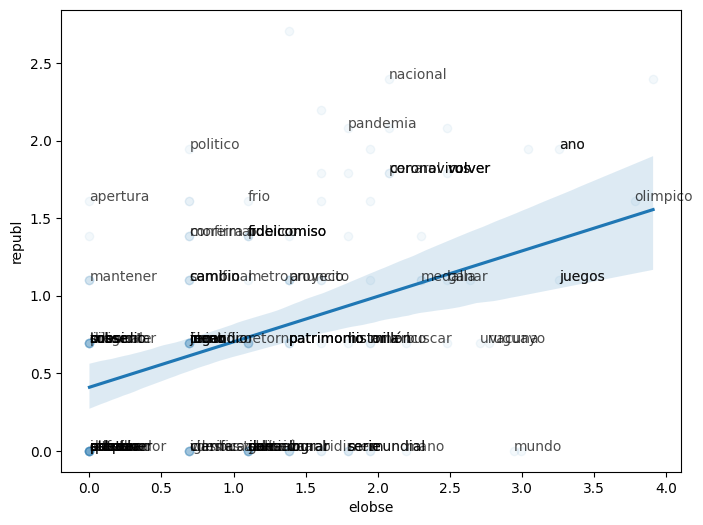

In [170]:
# Gráfico de correlación
# ==============================================================================
f, ax = plt.subplots(figsize=(8, 6))
temp = base_periodo_pivot.dropna()
sns.regplot(
    x  = np.log(temp.elobse),
    y  = np.log(temp.republ),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        s  = temp.index[i],# en otra version en lugar de s va text
        xy    = (np.log(temp.elobse[i]), np.log(temp.republ[i])),
        alpha = 0.7       
    )

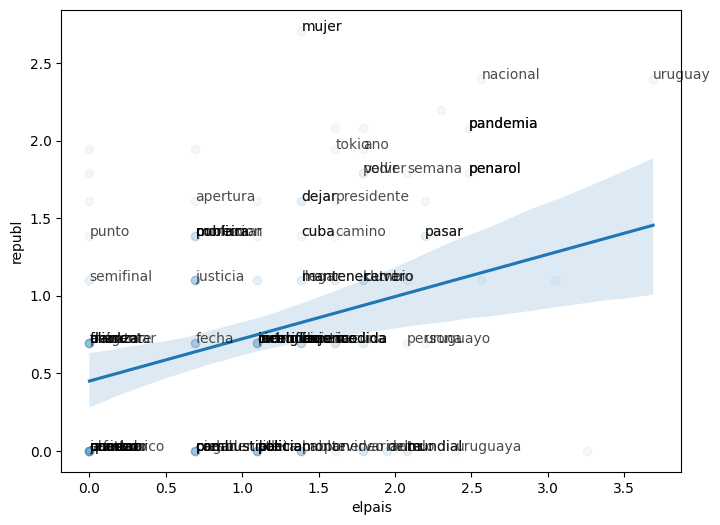

In [171]:
f, ax = plt.subplots(figsize=(8, 6))
temp = base_periodo_pivot.dropna()
sns.regplot(
    x  = np.log(temp.elpais),
    y  = np.log(temp.republ),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        s  = temp.index[i],# en otra version en lugar de s va text
        xy    = (np.log(temp.elpais[i]), np.log(temp.republ[i])),
        alpha = 0.7       
    )

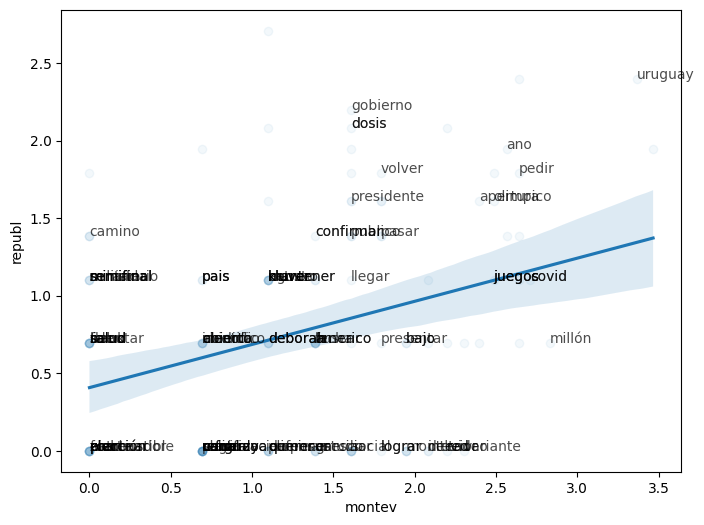

In [172]:
f, ax = plt.subplots(figsize=(8, 6))
temp = base_periodo_pivot.dropna()
sns.regplot(
    x  = np.log(temp.montev),
    y  = np.log(temp.republ),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        s  = temp.index[i],# en otra version en lugar de s va text
        xy    = (np.log(temp.montev[i]), np.log(temp.republ[i])),
        alpha = 0.7       
    )

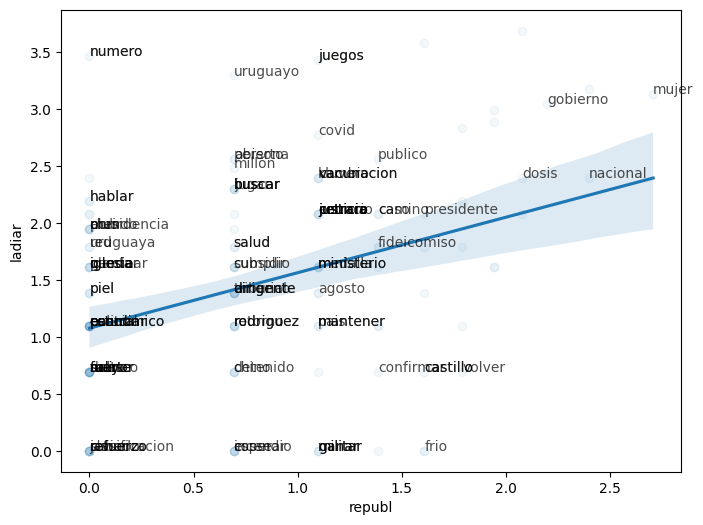

In [173]:
f, ax = plt.subplots(figsize=(8, 6))
temp = base_periodo_pivot.dropna()
sns.regplot(
    x  = np.log(temp.republ),
    y  = np.log(temp.ladiar),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        s  = temp.index[i],# en otra version en lugar de s va text
        xy    = (np.log(temp.republ[i]), np.log(temp.ladiar[i])),
        alpha = 0.7       
    )

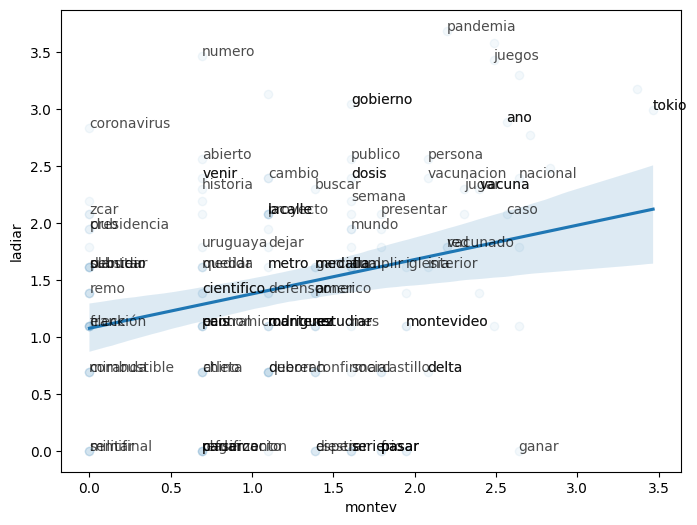

In [174]:
f, ax = plt.subplots(figsize=(8, 6))
temp = base_periodo_pivot.dropna()
sns.regplot(
    x  = np.log(temp.montev),
    y  = np.log(temp.ladiar),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        s  = temp.index[i],# en otra version en lugar de s va text
        xy    = (np.log(temp.montev[i]), np.log(temp.ladiar[i])),
        alpha = 0.7       
    )

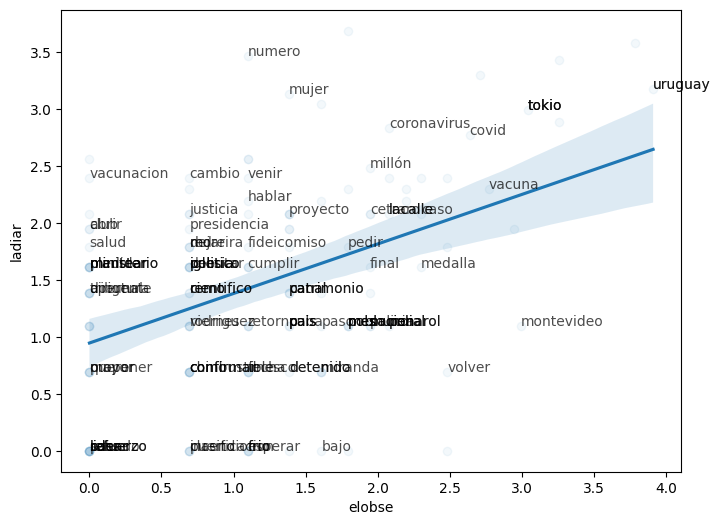

In [175]:
f, ax = plt.subplots(figsize=(8, 6))
temp = base_periodo_pivot.dropna()
sns.regplot(
    x  = np.log(temp.elobse),
    y  = np.log(temp.ladiar),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        s  = temp.index[i],# en otra version en lugar de s va text
        xy    = (np.log(temp.elobse[i]), np.log(temp.ladiar[i])),
        alpha = 0.7       
    )

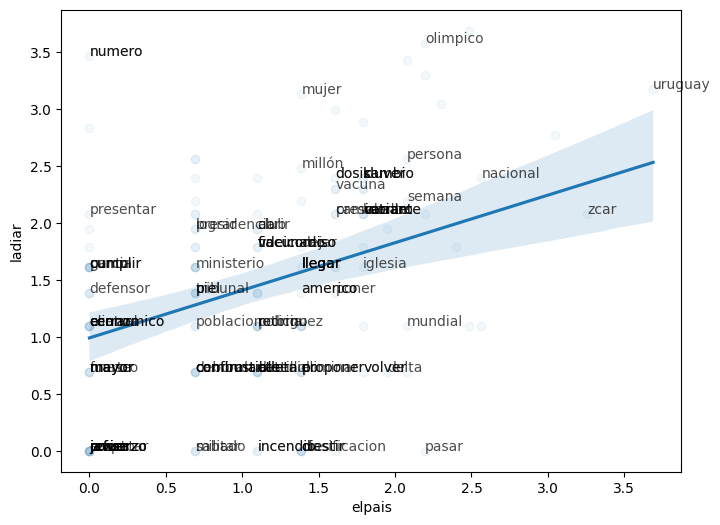

In [176]:
f, ax = plt.subplots(figsize=(8, 6))
temp = base_periodo_pivot.dropna()
sns.regplot(
    x  = np.log(temp.elpais),
    y  = np.log(temp.ladiar),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        s  = temp.index[i],# en otra version en lugar de s va text
        xy    = (np.log(temp.elpais[i]), np.log(temp.ladiar[i])),
        alpha = 0.7       
    )

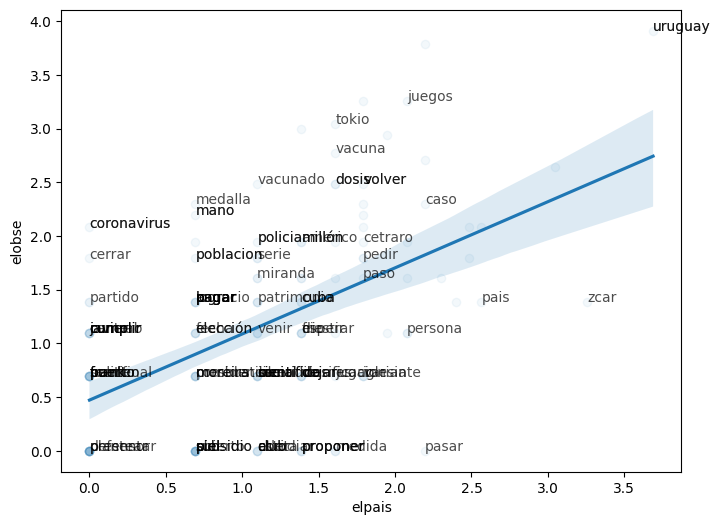

In [177]:
f, ax = plt.subplots(figsize=(8, 6))
temp = base_periodo_pivot.dropna()
sns.regplot(
    x  = np.log(temp.elpais),
    y  = np.log(temp.elobse),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        s  = temp.index[i],# en otra version en lugar de s va text
        xy    = (np.log(temp.elpais[i]), np.log(temp.elobse[i])),
        alpha = 0.7       
    )

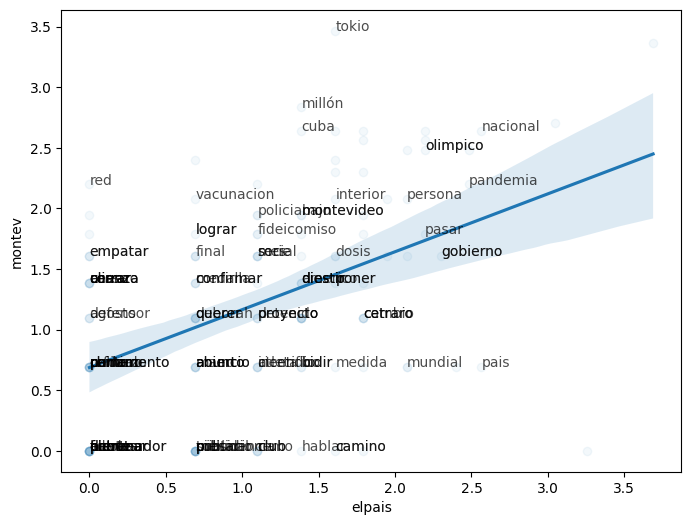

In [178]:
f, ax = plt.subplots(figsize=(8, 6))
temp = base_periodo_pivot.dropna()
sns.regplot(
    x  = np.log(temp.elpais),
    y  = np.log(temp.montev),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        s  = temp.index[i],# en otra version en lugar de s va text
        xy    = (np.log(temp.elpais[i]), np.log(temp.montev[i])),
        alpha = 0.7       
    )

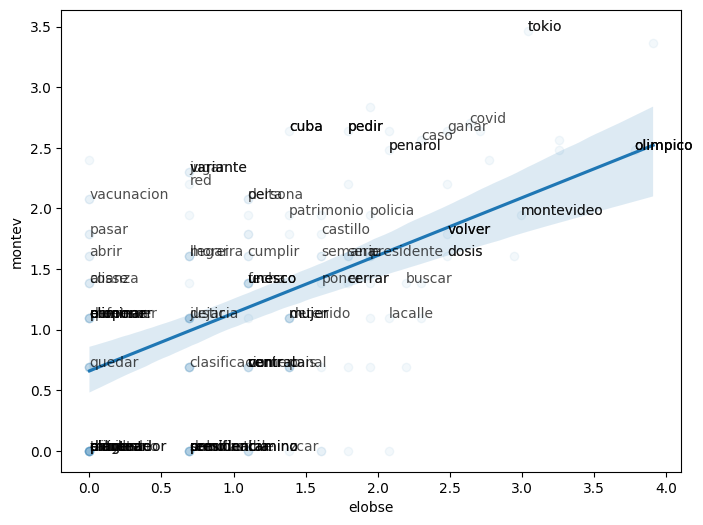

In [179]:
f, ax = plt.subplots(figsize=(8, 6))
temp = base_periodo_pivot.dropna()
sns.regplot(
    x  = np.log(temp.elobse),
    y  = np.log(temp.montev),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        s  = temp.index[i],# en otra version en lugar de s va text
        xy    = (np.log(temp.elobse[i]), np.log(temp.montev[i])),
        alpha = 0.7       
    )

In [180]:
# Cálculo del log of odds ratio de cada palabra (elobse vs republ)
# ==============================================================================
# Pivotaje y despivotaje
tit_pivot = base_periodo_tidy.groupby(["diario","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="diario", values= "count")

tit_pivot = tit_pivot.fillna(value=0)
tit_pivot.columns.name = None

tit_unpivot = tit_pivot.melt(value_name='n', var_name='diario', ignore_index=False)
tit_unpivot = tit_unpivot.reset_index()

# Selección de los diarios elobse y republ
tit_unpivot = tit_unpivot[tit_unpivot.diario.isin(['elobse', 'republ'])]

# Se añade el total de palabras de cada diario
tit_unpivot = tit_unpivot.merge(
                    base_periodo_tidy.groupby('diario')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'diario'
                 )

# Cálculo de odds y log of odds de cada palabra
tit_logOdds = tit_unpivot.copy()
tit_logOdds['odds'] = (tit_logOdds.n + 1) / (tit_logOdds.N + 1)
tit_logOdds = tit_logOdds[['token', 'diario', 'odds']] \
                    .pivot(index='token', columns='diario', values='odds')
tit_logOdds.columns.name = None

tit_logOdds['log_odds']     = np.log(tit_logOdds.elobse/tit_logOdds.republ)
tit_logOdds['abs_log_odds'] = np.abs(tit_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de elobse. Esto es así porque el ratio sea ha
# calculado como elobse/republ.
tit_logOdds['diario_frecuente'] = np.where(tit_logOdds.log_odds > 0,
                                              "elobse",
                                              "republ"
                                    )

In [181]:
tit_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

elobse    republ  log_odds  abs_log_odds diario_frecuente
token                                                                 
futuro     0.000305  0.006482 -3.057486      3.057486           republ
paro       0.000305  0.005893 -2.962176      2.962176           republ
educativo  0.000305  0.005893 -2.962176      2.962176           republ
realizar   0.000305  0.005893 -2.962176      2.962176           republ
teatro     0.000305  0.005303 -2.856816      2.856816           republ
ajedrez    0.000305  0.005303 -2.856816      2.856816           republ
carnaval   0.000305  0.005303 -2.856816      2.856816           republ
guarani    0.000305  0.005303 -2.856816      2.856816           republ
estacion   0.000305  0.005303 -2.856816      2.856816           republ
comuna     0.000305  0.005303 -2.856816      2.856816           republ

In [182]:
# Cálculo del log of odds ratio de cada palabra (elobse vs montev)
# ==============================================================================
# Pivotaje y despivotaje
tit_pivot = base_periodo_tidy.groupby(["diario","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="diario", values= "count")

tit_pivot = tit_pivot.fillna(value=0)
tit_pivot.columns.name = None

tit_unpivot = tit_pivot.melt(value_name='n', var_name='diario', ignore_index=False)
tit_unpivot = tit_unpivot.reset_index()

# Selección de los diarios elobse y montev
tit_unpivot = tit_unpivot[tit_unpivot.diario.isin(['elobse', 'montev'])]

# Se añade el total de palabras de cada diario
tit_unpivot = tit_unpivot.merge(
                    base_periodo_tidy.groupby('diario')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'diario'
                 )

# Cálculo de odds y log of odds de cada palabra
tit_logOdds = tit_unpivot.copy()
tit_logOdds['odds'] = (tit_logOdds.n + 1) / (tit_logOdds.N + 1)
tit_logOdds = tit_logOdds[['token', 'diario', 'odds']] \
                    .pivot(index='token', columns='diario', values='odds')
tit_logOdds.columns.name = None

tit_logOdds['log_odds']     = np.log(tit_logOdds.elobse/tit_logOdds.montev)
tit_logOdds['abs_log_odds'] = np.abs(tit_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de elobse. Esto es así porque el ratio sea ha
# calculado como elobse/montev.
tit_logOdds['diario_frecuente'] = np.where(tit_logOdds.log_odds > 0,
                                              "elobse",
                                              "montev"
                                    )

In [183]:
tit_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

elobse    montev  log_odds  abs_log_odds diario_frecuente
token                                                                  
pagina      0.005180  0.000278  2.925138      2.925138           elobse
observador  0.005180  0.000278  2.925138      2.925138           elobse
tokyo       0.004875  0.000278  2.864514      2.864514           elobse
empresa     0.004570  0.000278  2.799975      2.799975           elobse
peru        0.003961  0.000278  2.656875      2.656875           elobse
servicio    0.003047  0.000278  2.394510      2.394510           elobse
luna        0.000305  0.003057 -2.305970      2.305970           montev
panoramico  0.002742  0.000278  2.289150      2.289150           elobse
funebr      0.002742  0.000278  2.289150      2.289150           elobse
mirador     0.002742  0.000278  2.289150      2.289150           elobse

In [184]:
# Cálculo del log of odds ratio de cada palabra (elobse vs elpais)
# ==============================================================================
# Pivotaje y despivotaje
tit_pivot = base_periodo_tidy.groupby(["diario","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="diario", values= "count")

tit_pivot = tit_pivot.fillna(value=0)
tit_pivot.columns.name = None

tit_unpivot = tit_pivot.melt(value_name='n', var_name='diario', ignore_index=False)
tit_unpivot = tit_unpivot.reset_index()

# Selección de los diarios elobse y elpais
tit_unpivot = tit_unpivot[tit_unpivot.diario.isin(['elobse', 'elpais'])]

# Se añade el total de palabras de cada diario
tit_unpivot = tit_unpivot.merge(
                    base_periodo_tidy.groupby('diario')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'diario'
                 )

# Cálculo de odds y log of odds de cada palabra
tit_logOdds = tit_unpivot.copy()
tit_logOdds['odds'] = (tit_logOdds.n + 1) / (tit_logOdds.N + 1)
tit_logOdds = tit_logOdds[['token', 'diario', 'odds']] \
                    .pivot(index='token', columns='diario', values='odds')
tit_logOdds.columns.name = None

tit_logOdds['log_odds']     = np.log(tit_logOdds.elobse/tit_logOdds.elpais)
tit_logOdds['abs_log_odds'] = np.abs(tit_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de elobse. Esto es así porque el ratio sea ha
# calculado como elobse/elpais.
tit_logOdds['diario_frecuente'] = np.where(tit_logOdds.log_odds > 0,
                                              "elobse",
                                              "elpais"
                                    )

In [185]:
tit_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

elobse    elpais  log_odds  abs_log_odds diario_frecuente
token                                                                  
observador  0.005180  0.000310  2.814452      2.814452           elobse
pagina      0.005180  0.000310  2.814452      2.814452           elobse
tokyo       0.004875  0.000310  2.753828      2.753828           elobse
brasil      0.000305  0.003415 -2.416656      2.416656           elpais
economia    0.000305  0.003105 -2.321346      2.321346           elpais
costa       0.003047  0.000310  2.283824      2.283824           elobse
suscribite  0.000305  0.002794 -2.215986      2.215986           elpais
contenido   0.000305  0.002794 -2.215986      2.215986           elpais
horoscopo   0.000305  0.002794 -2.215986      2.215986           elpais
leer        0.000305  0.002794 -2.215986      2.215986           elpais

In [186]:
# Cálculo del log of odds ratio de cada palabra (elobse vs ladiar)
# ==============================================================================
# Pivotaje y despivotaje
tit_pivot = base_periodo_tidy.groupby(["diario","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="diario", values= "count")

tit_pivot = tit_pivot.fillna(value=0)
tit_pivot.columns.name = None

tit_unpivot = tit_pivot.melt(value_name='n', var_name='diario', ignore_index=False)
tit_unpivot = tit_unpivot.reset_index()

# Selección de los diarios elobse y ladiar
tit_unpivot = tit_unpivot[tit_unpivot.diario.isin(['elobse', 'ladiar'])]

# Se añade el total de palabras de cada diario
tit_unpivot = tit_unpivot.merge(
                    base_periodo_tidy.groupby('diario')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'diario'
                 )

# Cálculo de odds y log of odds de cada palabra
tit_logOdds = tit_unpivot.copy()
tit_logOdds['odds'] = (tit_logOdds.n + 1) / (tit_logOdds.N + 1)
tit_logOdds = tit_logOdds[['token', 'diario', 'odds']] \
                    .pivot(index='token', columns='diario', values='odds')
tit_logOdds.columns.name = None

tit_logOdds['log_odds']     = np.log(tit_logOdds.elobse/tit_logOdds.ladiar)
tit_logOdds['abs_log_odds'] = np.abs(tit_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de elobse. Esto es así porque el ratio sea ha
# calculado como elobse/ladiar.
tit_logOdds['diario_frecuente'] = np.where(tit_logOdds.log_odds > 0,
                                              "elobse",
                                              "ladiar"
                                    )

In [187]:
tit_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

elobse    ladiar  log_odds  abs_log_odds diario_frecuente
token                                                                  
gigante     0.000305  0.008150 -3.286529      3.286529           ladiar
pagina      0.005180  0.000209  3.210246      3.210246           elobse
observador  0.005180  0.000209  3.210246      3.210246           elobse
tokyo       0.004875  0.000209  3.149622      3.149622           elobse
rendicion   0.000305  0.006897 -3.119475      3.119475           ladiar
apunte      0.000305  0.006897 -3.119475      3.119475           ladiar
tiempo      0.000305  0.006270 -3.024164      3.024164           ladiar
mirar       0.003047  0.000209  2.679618      2.679618           elobse
costa       0.003047  0.000209  2.679618      2.679618           elobse
zquer       0.002742  0.000209  2.574258      2.574258           elobse

In [188]:
# Cálculo del log of odds ratio de cada palabra (elpais vs ladiar)
# ==============================================================================
# Pivotaje y despivotaje
tit_pivot = base_periodo_tidy.groupby(["diario","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="diario", values= "count")

tit_pivot = tit_pivot.fillna(value=0)
tit_pivot.columns.name = None

tit_unpivot = tit_pivot.melt(value_name='n', var_name='diario', ignore_index=False)
tit_unpivot = tit_unpivot.reset_index()

# Selección de los diarios elpais y ladiar
tit_unpivot = tit_unpivot[tit_unpivot.diario.isin(['elpais', 'ladiar'])]

# Se añade el total de palabras de cada diario
tit_unpivot = tit_unpivot.merge(
                    base_periodo_tidy.groupby('diario')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'diario'
                 )

# Cálculo de odds y log of odds de cada palabra
tit_logOdds = tit_unpivot.copy()
tit_logOdds['odds'] = (tit_logOdds.n + 1) / (tit_logOdds.N + 1)
tit_logOdds = tit_logOdds[['token', 'diario', 'odds']] \
                    .pivot(index='token', columns='diario', values='odds')
tit_logOdds.columns.name = None

tit_logOdds['log_odds']     = np.log(tit_logOdds.elpais/tit_logOdds.ladiar)
tit_logOdds['abs_log_odds'] = np.abs(tit_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de elobse. Esto es así porque el ratio sea ha
# calculado como elpais/ladiar.
tit_logOdds['diario_frecuente'] = np.where(tit_logOdds.log_odds > 0,
                                              "elpais",
                                              "ladiar"
                                    )

In [189]:
tit_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

elpais    ladiar  log_odds  abs_log_odds diario_frecuente
token                                                                  
gigante     0.000310  0.008150 -3.267767      3.267767           ladiar
julio       0.004036  0.000209  2.960744      2.960744           elpais
economia    0.003105  0.000209  2.698379      2.698379           elpais
horoscopo   0.002794  0.000209  2.593019      2.593019           elpais
susana      0.002794  0.000209  2.593019      2.593019           elpais
garbuyo     0.002794  0.000209  2.593019      2.593019           elpais
contenido   0.002794  0.000209  2.593019      2.593019           elpais
leer        0.002794  0.000209  2.593019      2.593019           elpais
suscribite  0.002794  0.000209  2.593019      2.593019           elpais
ciudad      0.000310  0.003971 -2.548645      2.548645           ladiar

SENTIMIENTO

In [190]:
tabla_datos = pd.crosstab(index=base_periodo['sentimiento'], \
                          columns=base_periodo['diario'], margins=True)
# si saco margins=True me da solo los valores
tabla_datos


diario       elobse  elpais  ladiar  montev  republ   All
sentimiento                                              
NEG              86      87     101      79      40   393
NEU             404     397     574     429     340  2144
POS              59      52      36      50      24   221
All             549     536     711     558     404  2758

In [191]:
#from google.colab import files
#tabla_datos.to_csv('frecuencia_valores.csv')
#files.download('frecuencia_valores.csv')

In [192]:
tabla_datos_porcen = pd.crosstab(index=base_periodo['sentimiento'], \
                          columns=base_periodo['diario'], margins=True, normalize='columns')
# si saco margins=True me da solo los valores

tabla_datos_porcen


diario         elobse    elpais    ladiar    montev    republ       All
sentimiento                                                            
NEG          0.156648  0.162313  0.142053  0.141577  0.099010  0.142495
NEU          0.735883  0.740672  0.807314  0.768817  0.841584  0.777375
POS          0.107468  0.097015  0.050633  0.089606  0.059406  0.080131

In [193]:
#tabla_datos_porcen.to_csv('frecuencia_porcentajes.csv')
#files.download('frecuencia_porcentajes.csv')

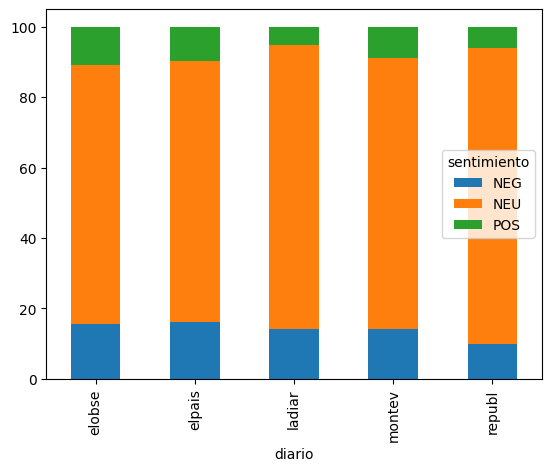

In [194]:
# esto lo saqué de: https://relopezbriega.github.io/blog/2016/02/29/analisis-de-datos-categoricos-con-python/
#, stacked=True
plot = pd.crosstab(index=base_periodo['diario'],
            columns=base_periodo['sentimiento']
                  ).apply(lambda r: r/r.sum() *100,
                          axis=1).plot(kind='bar', stacked=True)

#plt.savefig("barras_sentimiento.jpg", bbox_inches='tight')
#files.download("barras_sentimiento.jpg")